In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", style="whitegrid")

df6040 = pd.read_csv("experiment_data_6040.csv")
df8020 = pd.read_csv("experiment_data_8020.csv")
df9505 = pd.read_csv("experiment_data_9505.csv")

In [3]:
#normalize pixel scores by using samples_size**2 as the maximum possible score, read the sample_size from the folder name
df6040['list_of_pixel_score'] = df6040['list_of_pixel_score'].apply(eval).apply(np.array)
df8020['list_of_pixel_score'] = df8020['list_of_pixel_score'].apply(eval).apply(np.array)
df9505['list_of_pixel_score'] = df9505['list_of_pixel_score'].apply(eval).apply(np.array)
df6040["normalized_pixel_score"] = df6040["list_of_pixel_score"] / (df6040["sample_size"].astype(int) ** 2)
df8020["normalized_pixel_score"] = df8020["list_of_pixel_score"] / (df8020["sample_size"].astype(int) ** 2)
df9505["normalized_pixel_score"] = df9505["list_of_pixel_score"] / (df9505["sample_size"].astype(int) ** 2)

#create mean, std, min, max columns for normalized_pixel_score
def compute_stats(df):
    df["mean_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.mean)
    df["std_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.std)
    df["min_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.min)
    df["max_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.max)
    return df
df6040 = compute_stats(df6040)
df8020 = compute_stats(df8020)
df9505 = compute_stats(df9505)

In [4]:
# for run 0 combine all batches into one list 
def combine_batches(df, run_number="0"):
    df_run0 = df[df["run_number"] == run_number].copy()
    df_run0 = df_run0.groupby(["sample_size", "volume_depth"]).agg({
        "normalized_pixel_score": lambda x: np.concatenate(x.values)
    }).reset_index()
    return df_run0
df6040_run0 = combine_batches(df6040, run_number="0")
df8020_run0 = combine_batches(df8020, run_number="0")
df9505_run0 = combine_batches(df9505, run_number="0")
df6040_rundataset = combine_batches(df6040, run_number="dataset")
df8020_rundataset = combine_batches(df8020, run_number="dataset")
df9505_rundataset = combine_batches(df9505, run_number="dataset")

In [5]:
#for each entry in df_run0 get the mean, std, min, max of normalized_pixel_score 
def compute_stats_run0(df_run0):
    df_run0['mean'] = df_run0["normalized_pixel_score"].apply(np.mean)
    df_run0['std'] = df_run0["normalized_pixel_score"].apply(np.std)
    df_run0['min'] = df_run0["normalized_pixel_score"].apply(np.min)
    df_run0['max']= df_run0["normalized_pixel_score"].apply(np.max)
    return df_run0
df6040_run0 = compute_stats_run0(df6040_run0)
df8020_run0 = compute_stats_run0(df8020_run0)
df9505_run0 = compute_stats_run0(df9505_run0)
df6040_rundataset = compute_stats_run0(df6040_rundataset)
df8020_rundataset = compute_stats_run0(df8020_rundataset)
df9505_rundataset = compute_stats_run0(df9505_rundataset)

print(len(df6040[df6040["run_number"]=="dataset"]),len(df6040),len(df8020), len(df9505))


2088 3213 5718 10873


In [6]:
#combine the two plots above into one 3d plot   
def plot_3d_surface(df, title):
    fig = plt.figure(figsize=(10,8),dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    # create a meshgrid of sample_size and volume_depth
    sample_sizes = df["sample_size"].astype(int).unique()
    volume_depths = df["volume_depth"].astype(int).unique()
    X, Y = np.meshgrid(sample_sizes, volume_depths)
    # get the mean values for each combination of sample_size and volume_depth
    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            sample_size = X[i, j]
            volume_depth = Y[i, j]
            mean_value = df[(df["sample_size"] == sample_size) & (df["volume_depth"] == volume_depth)]["mean"].values
            if len(mean_value) > 0:
                Z[i, j] = mean_value[0]
            else:
                Z[i, j] = np.nan
    # plot the surface
    surf = ax.plot_surface(Y, X, Z, cmap='viridis', edgecolor='none', alpha=0.6)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    # calculate the std and add it as error bars to each point
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            sample_size = X[i, j]
            volume_depth = Y[i, j]
            std_value = df[(df["sample_size"] == sample_size) & (df["volume_depth"] == volume_depth)]["std"].values
            mean_value = df[(df["sample_size"] == sample_size) & (df["volume_depth"] == volume_depth)]["mean"].values
            print(f"Sample Size: {sample_size}, Volume Depth: {volume_depth}, Mean: {mean_value}, Std: {std_value}")
            if len(std_value) > 0 and len(mean_value) > 0:
                ax.plot([volume_depth, volume_depth], [sample_size, sample_size], 
                        [mean_value[0] - std_value[0], mean_value[0] + std_value[0]], 
                        color='r', alpha=0.8, marker='_',markersize=10)
            

    ax.set_ylabel('Sample Size')
    ax.set_xlabel('Volume Depth')
    ax.set_zlabel('Normalized Mean Pixel Score')
    #set z limit to 0,1
    ax.set_zlim(0.0, 1)
    ax.set_xticks(volume_depths)
    ax.set_xticklabels(volume_depths)
    ax.set_yticks(sample_sizes)
    ax.set_yticklabels(sample_sizes)
    #ax.set_title(f'3D Surface Plot of Mean Normalized Pixel Score - {title} Dataset')
    plt.show()




In [7]:
#combine the two plots above into one 3d plot   
def plot_3d_surface_max(df, title):
    fig = plt.figure(figsize=(10,8),dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    # create a meshgrid of sample_size and volume_depth
    sample_sizes = df["sample_size"].astype(int).unique()
    volume_depths = df["volume_depth"].astype(int).unique()
    X, Y = np.meshgrid(sample_sizes, volume_depths)
    # get the mean values for each combination of sample_size and volume_depth
    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            sample_size = X[i, j]
            volume_depth = Y[i, j]
            mean_value = df[(df["sample_size"] == sample_size) & (df["volume_depth"] == volume_depth)]["max"].values
            if len(mean_value) > 0:
                Z[i, j] = mean_value[0]
            else:
                Z[i, j] = np.nan
            
            print(f"Sample Size: {sample_size}, Volume Depth: {volume_depth}, Max: {mean_value}")
    # plot the surface
    surf = ax.plot_surface(Y, X, Z, cmap='viridis', edgecolor='none', alpha=0.6)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
            

    ax.set_ylabel('Sample Size')
    ax.set_xlabel('Volume Depth')
    ax.set_zlabel('Max Normalized Pixel Score')
    #set z limit to 0,1
    ax.set_zlim(0.0, 1)
    ax.set_xticks(volume_depths)
    ax.set_xticklabels(volume_depths)
    ax.set_yticks(sample_sizes)
    ax.set_yticklabels(sample_sizes)
    #ax.set_title(f'3D Surface Plot of Max Normalized Pixel Score - {title} Dataset')
    plt.show()




Sample Size: 8, Volume Depth: 8, Max: [0.578125]
Sample Size: 16, Volume Depth: 8, Max: [0.4375]
Sample Size: 32, Volume Depth: 8, Max: [0.51660156]
Sample Size: 8, Volume Depth: 16, Max: [0.5625]
Sample Size: 16, Volume Depth: 16, Max: [0.48828125]
Sample Size: 32, Volume Depth: 16, Max: [0.54296875]
Sample Size: 8, Volume Depth: 32, Max: [0.578125]
Sample Size: 16, Volume Depth: 32, Max: [0.58984375]
Sample Size: 32, Volume Depth: 32, Max: [0.44335938]


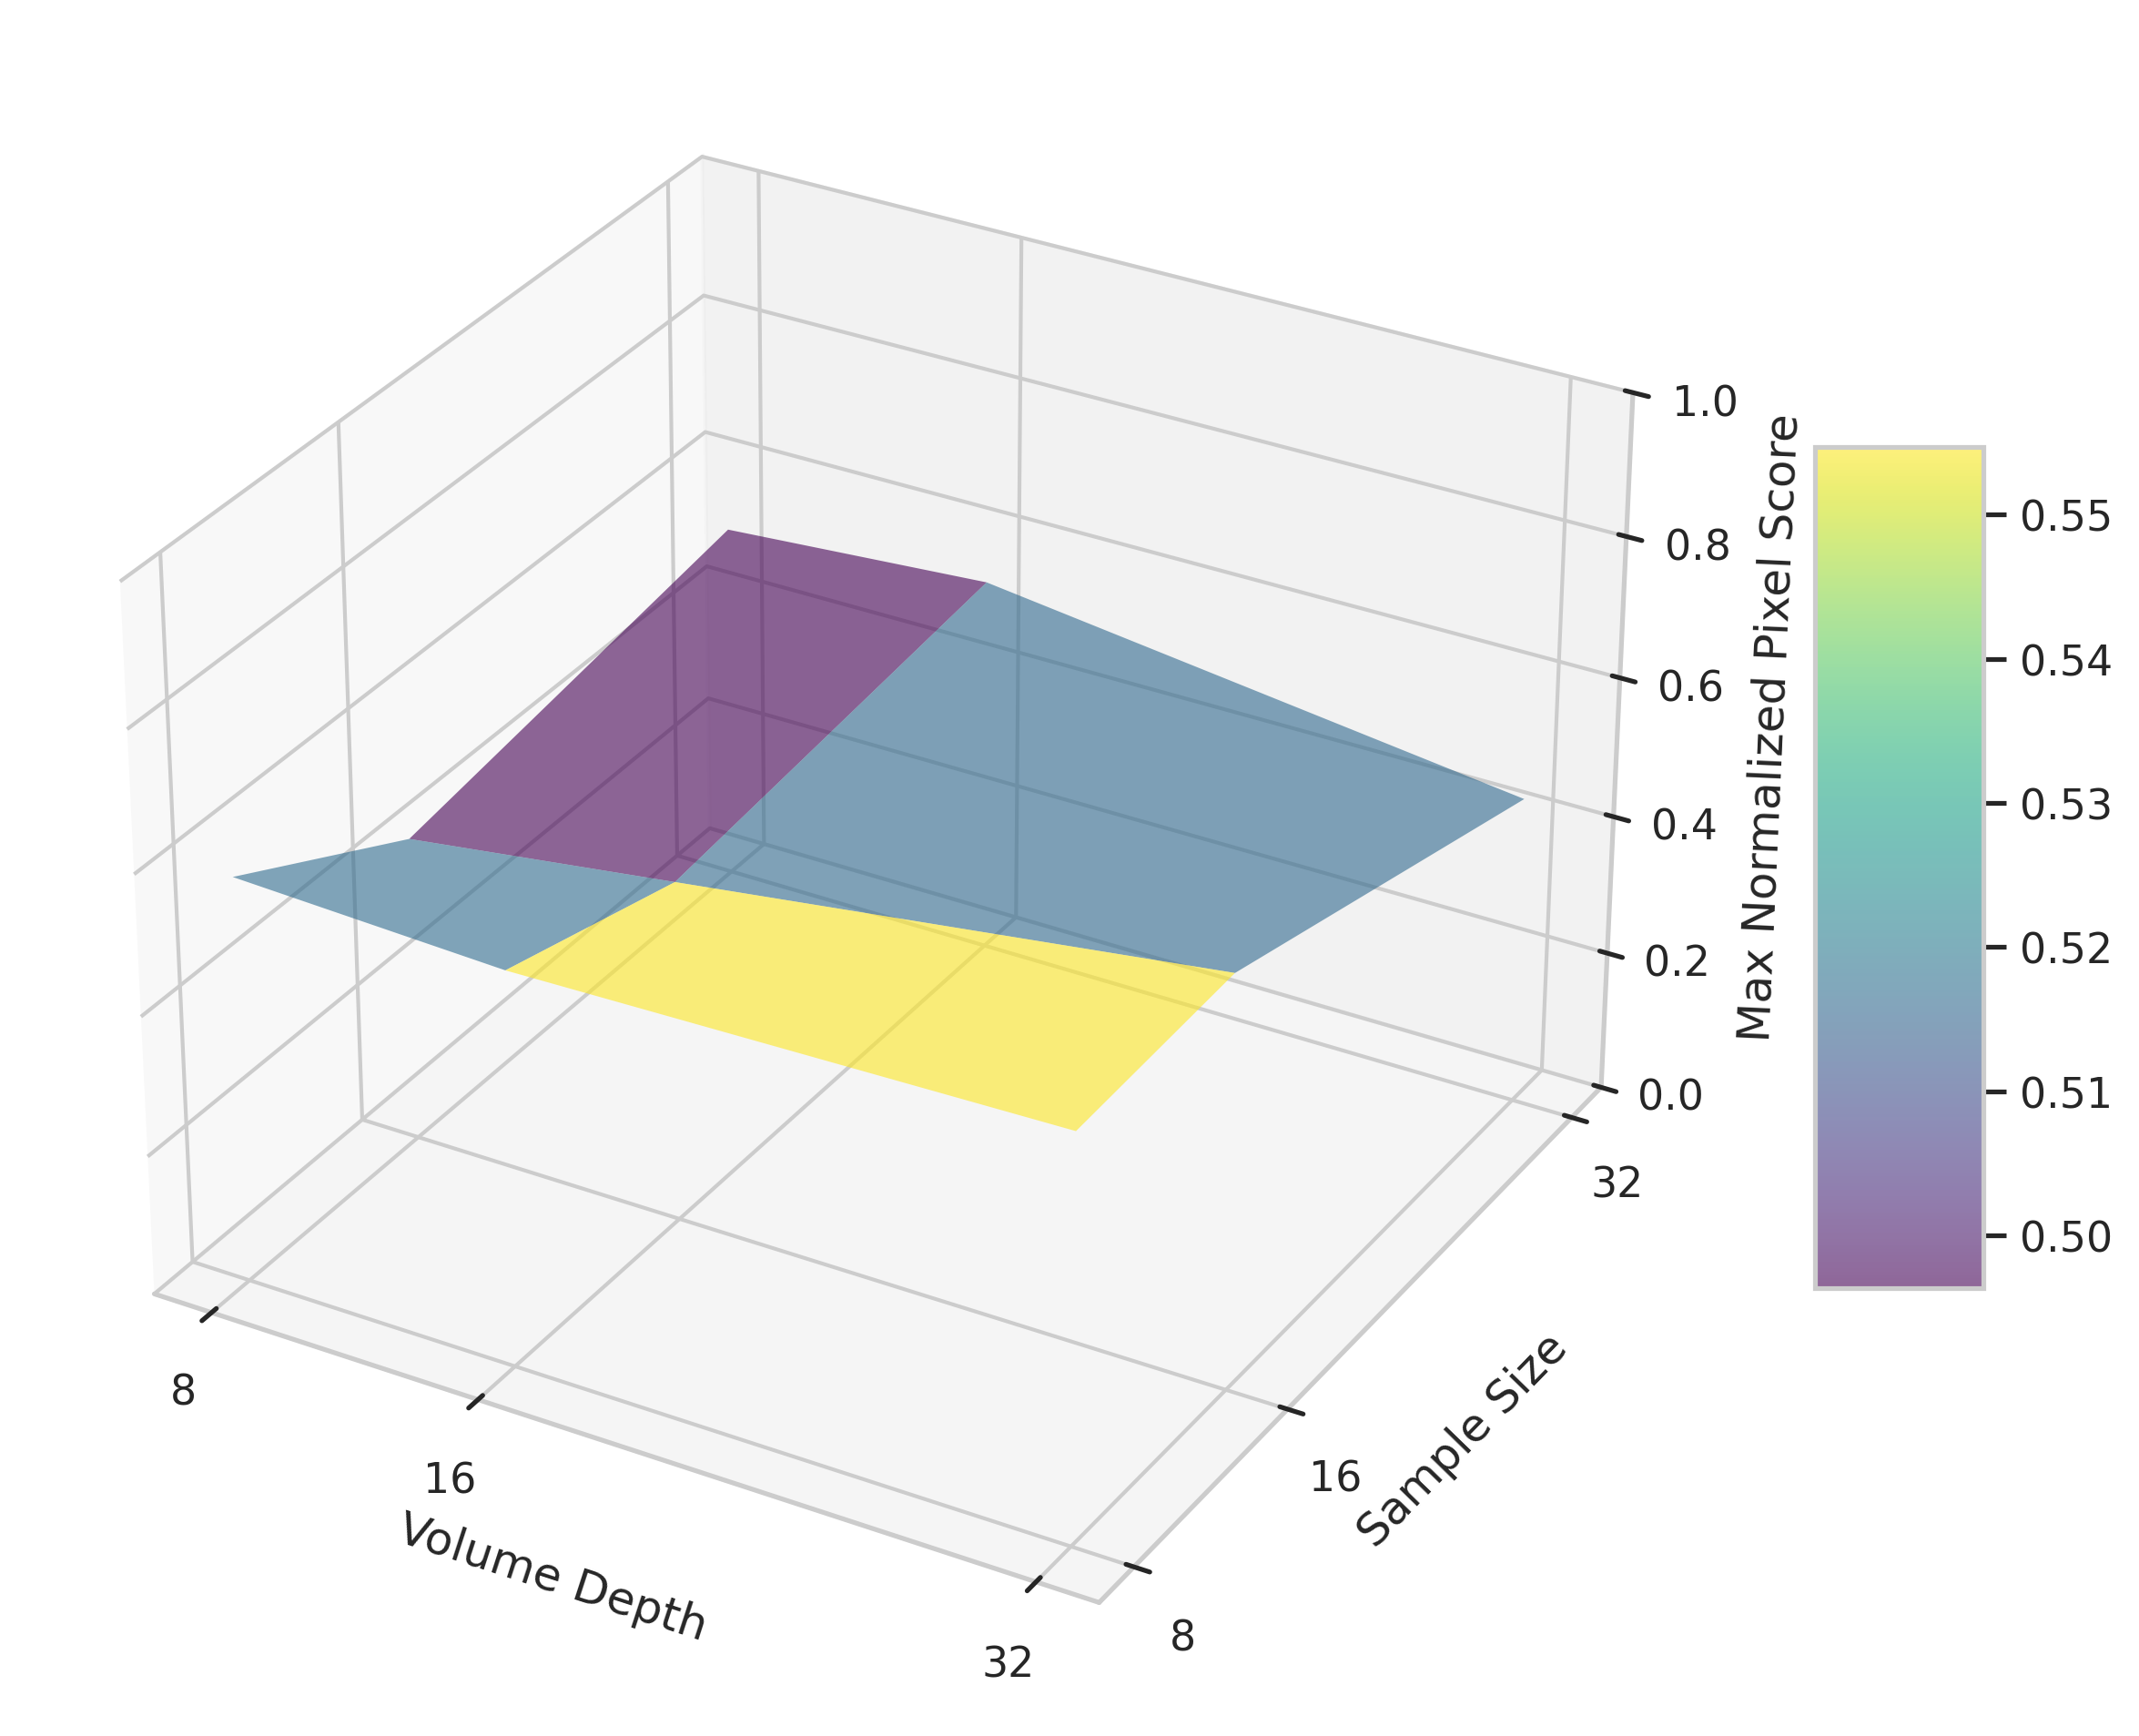

Sample Size: 8, Volume Depth: 8, Max: [0.75]
Sample Size: 16, Volume Depth: 8, Max: [0.70703125]
Sample Size: 32, Volume Depth: 8, Max: [0.71191406]
Sample Size: 8, Volume Depth: 16, Max: [0.75]
Sample Size: 16, Volume Depth: 16, Max: [0.65625]
Sample Size: 32, Volume Depth: 16, Max: [0.7578125]
Sample Size: 8, Volume Depth: 32, Max: [0.734375]
Sample Size: 16, Volume Depth: 32, Max: [0.68359375]
Sample Size: 32, Volume Depth: 32, Max: [0.6171875]


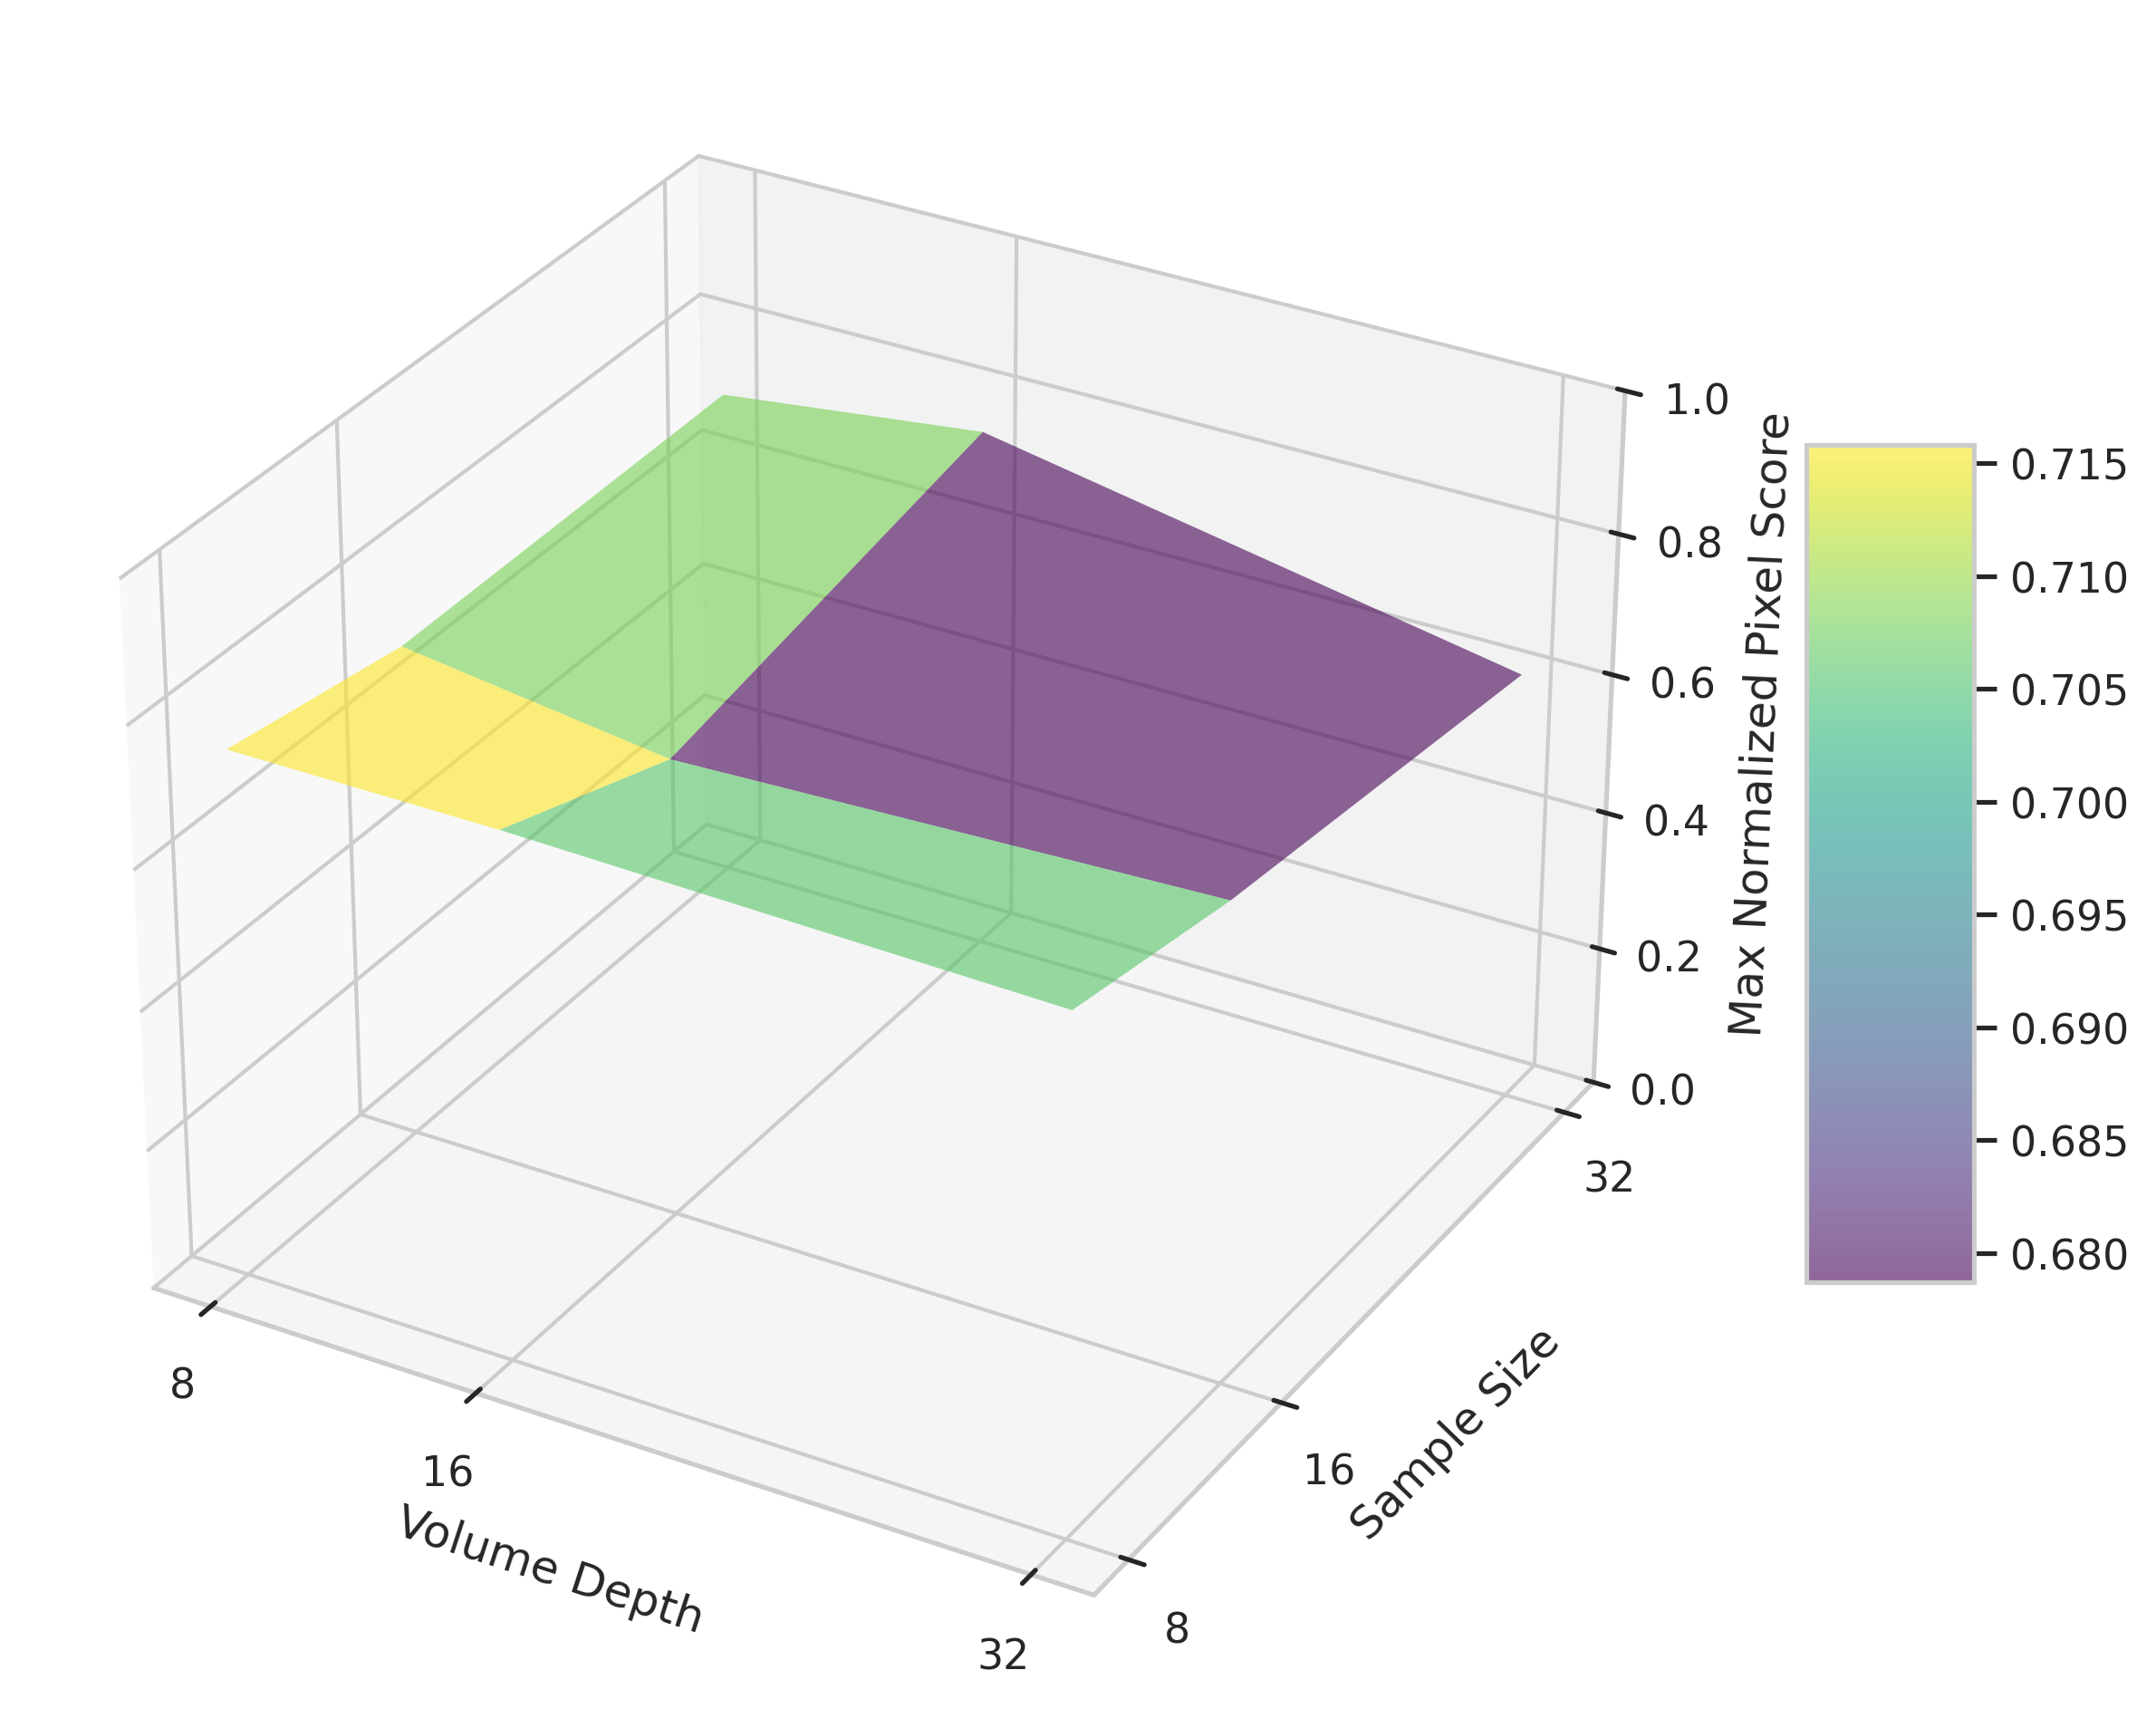

Sample Size: 8, Volume Depth: 8, Max: [0.9375]
Sample Size: 16, Volume Depth: 8, Max: [0.90234375]
Sample Size: 32, Volume Depth: 8, Max: [0.91699219]
Sample Size: 8, Volume Depth: 16, Max: [0.84375]
Sample Size: 16, Volume Depth: 16, Max: [0.9140625]
Sample Size: 32, Volume Depth: 16, Max: [0.92578125]
Sample Size: 8, Volume Depth: 32, Max: [0.9375]
Sample Size: 16, Volume Depth: 32, Max: [0.92578125]
Sample Size: 32, Volume Depth: 32, Max: [0.79882812]


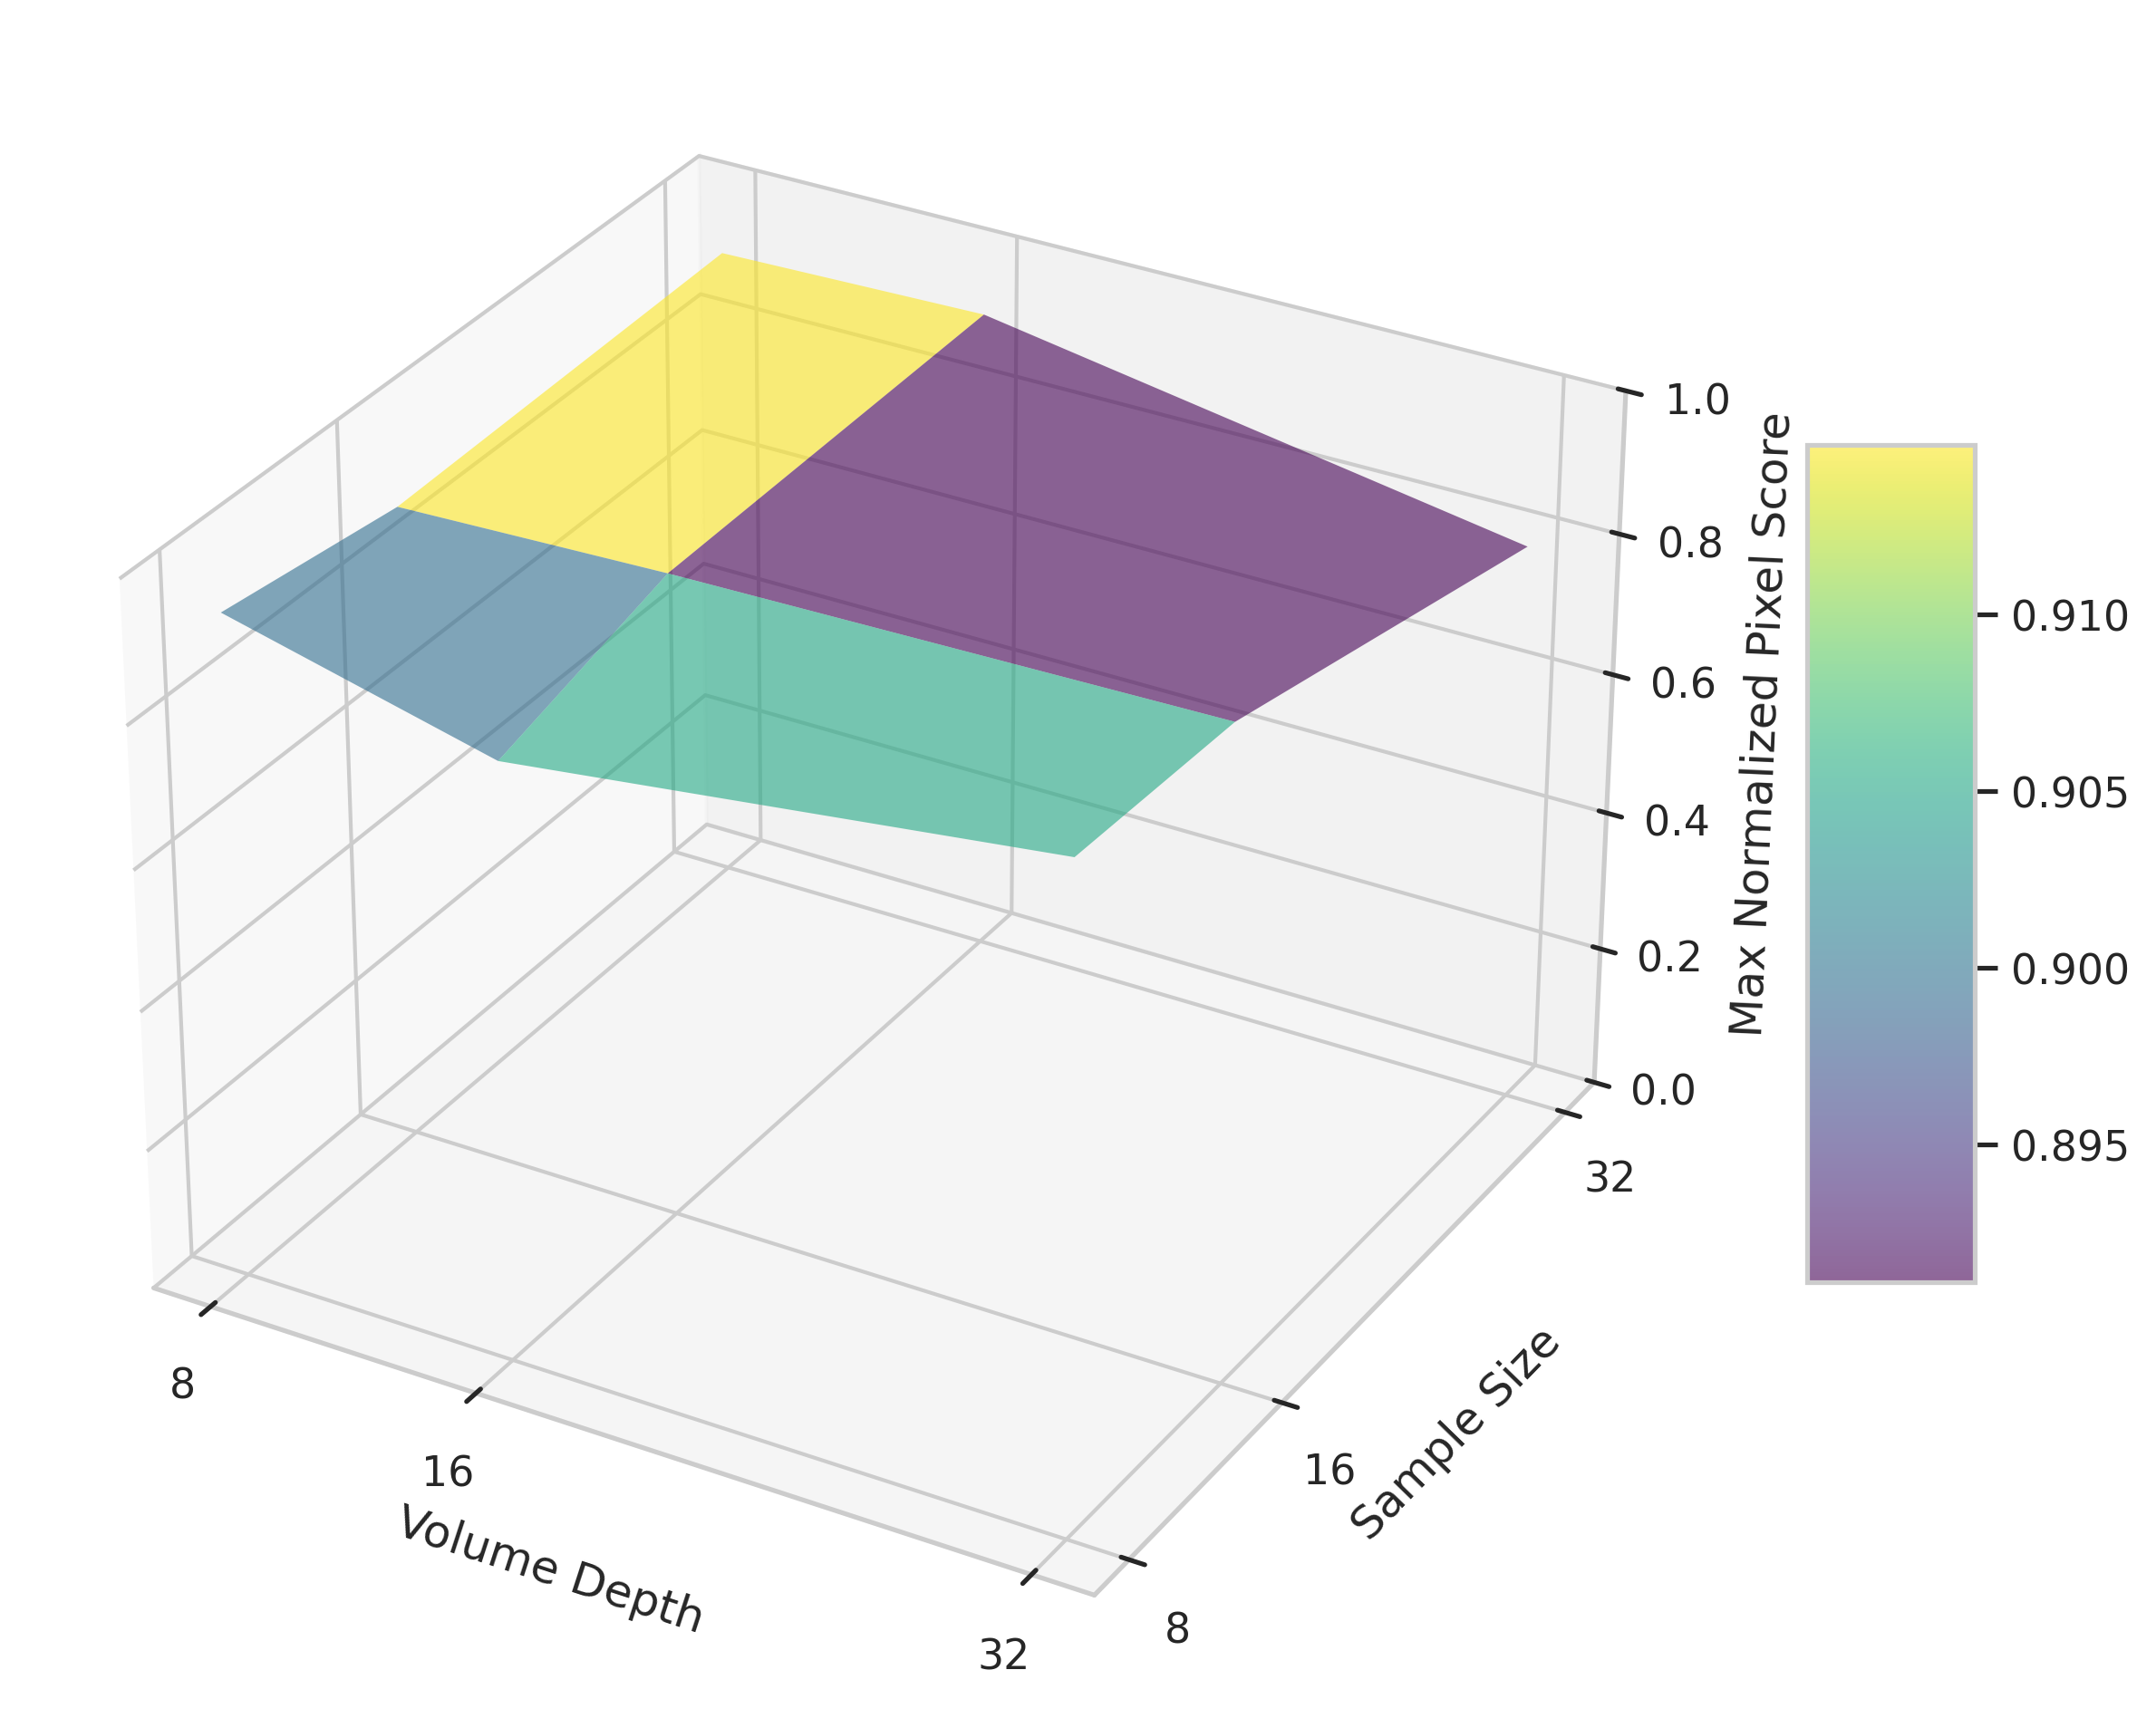

In [8]:
plot_3d_surface_max(df6040_run0, "60-40")
plot_3d_surface_max(df8020_run0, "80-20")
plot_3d_surface_max(df9505_run0, "95-05")

Sample Size: 8, Volume Depth: 8, Mean: [0.15316271], Std: [0.15824881]
Sample Size: 16, Volume Depth: 8, Mean: [0.09907618], Std: [0.0658946]
Sample Size: 32, Volume Depth: 8, Mean: [0.15750473], Std: [0.12615456]
Sample Size: 8, Volume Depth: 16, Mean: [0.12339744], Std: [0.14652024]
Sample Size: 16, Volume Depth: 16, Mean: [0.15642387], Std: [0.10627029]
Sample Size: 32, Volume Depth: 16, Mean: [0.0704072], Std: [0.0952867]
Sample Size: 8, Volume Depth: 32, Mean: [0.1781085], Std: [0.15360456]
Sample Size: 16, Volume Depth: 32, Mean: [0.18357057], Std: [0.14395854]
Sample Size: 32, Volume Depth: 32, Mean: [0.00488281], Std: [0.02771036]


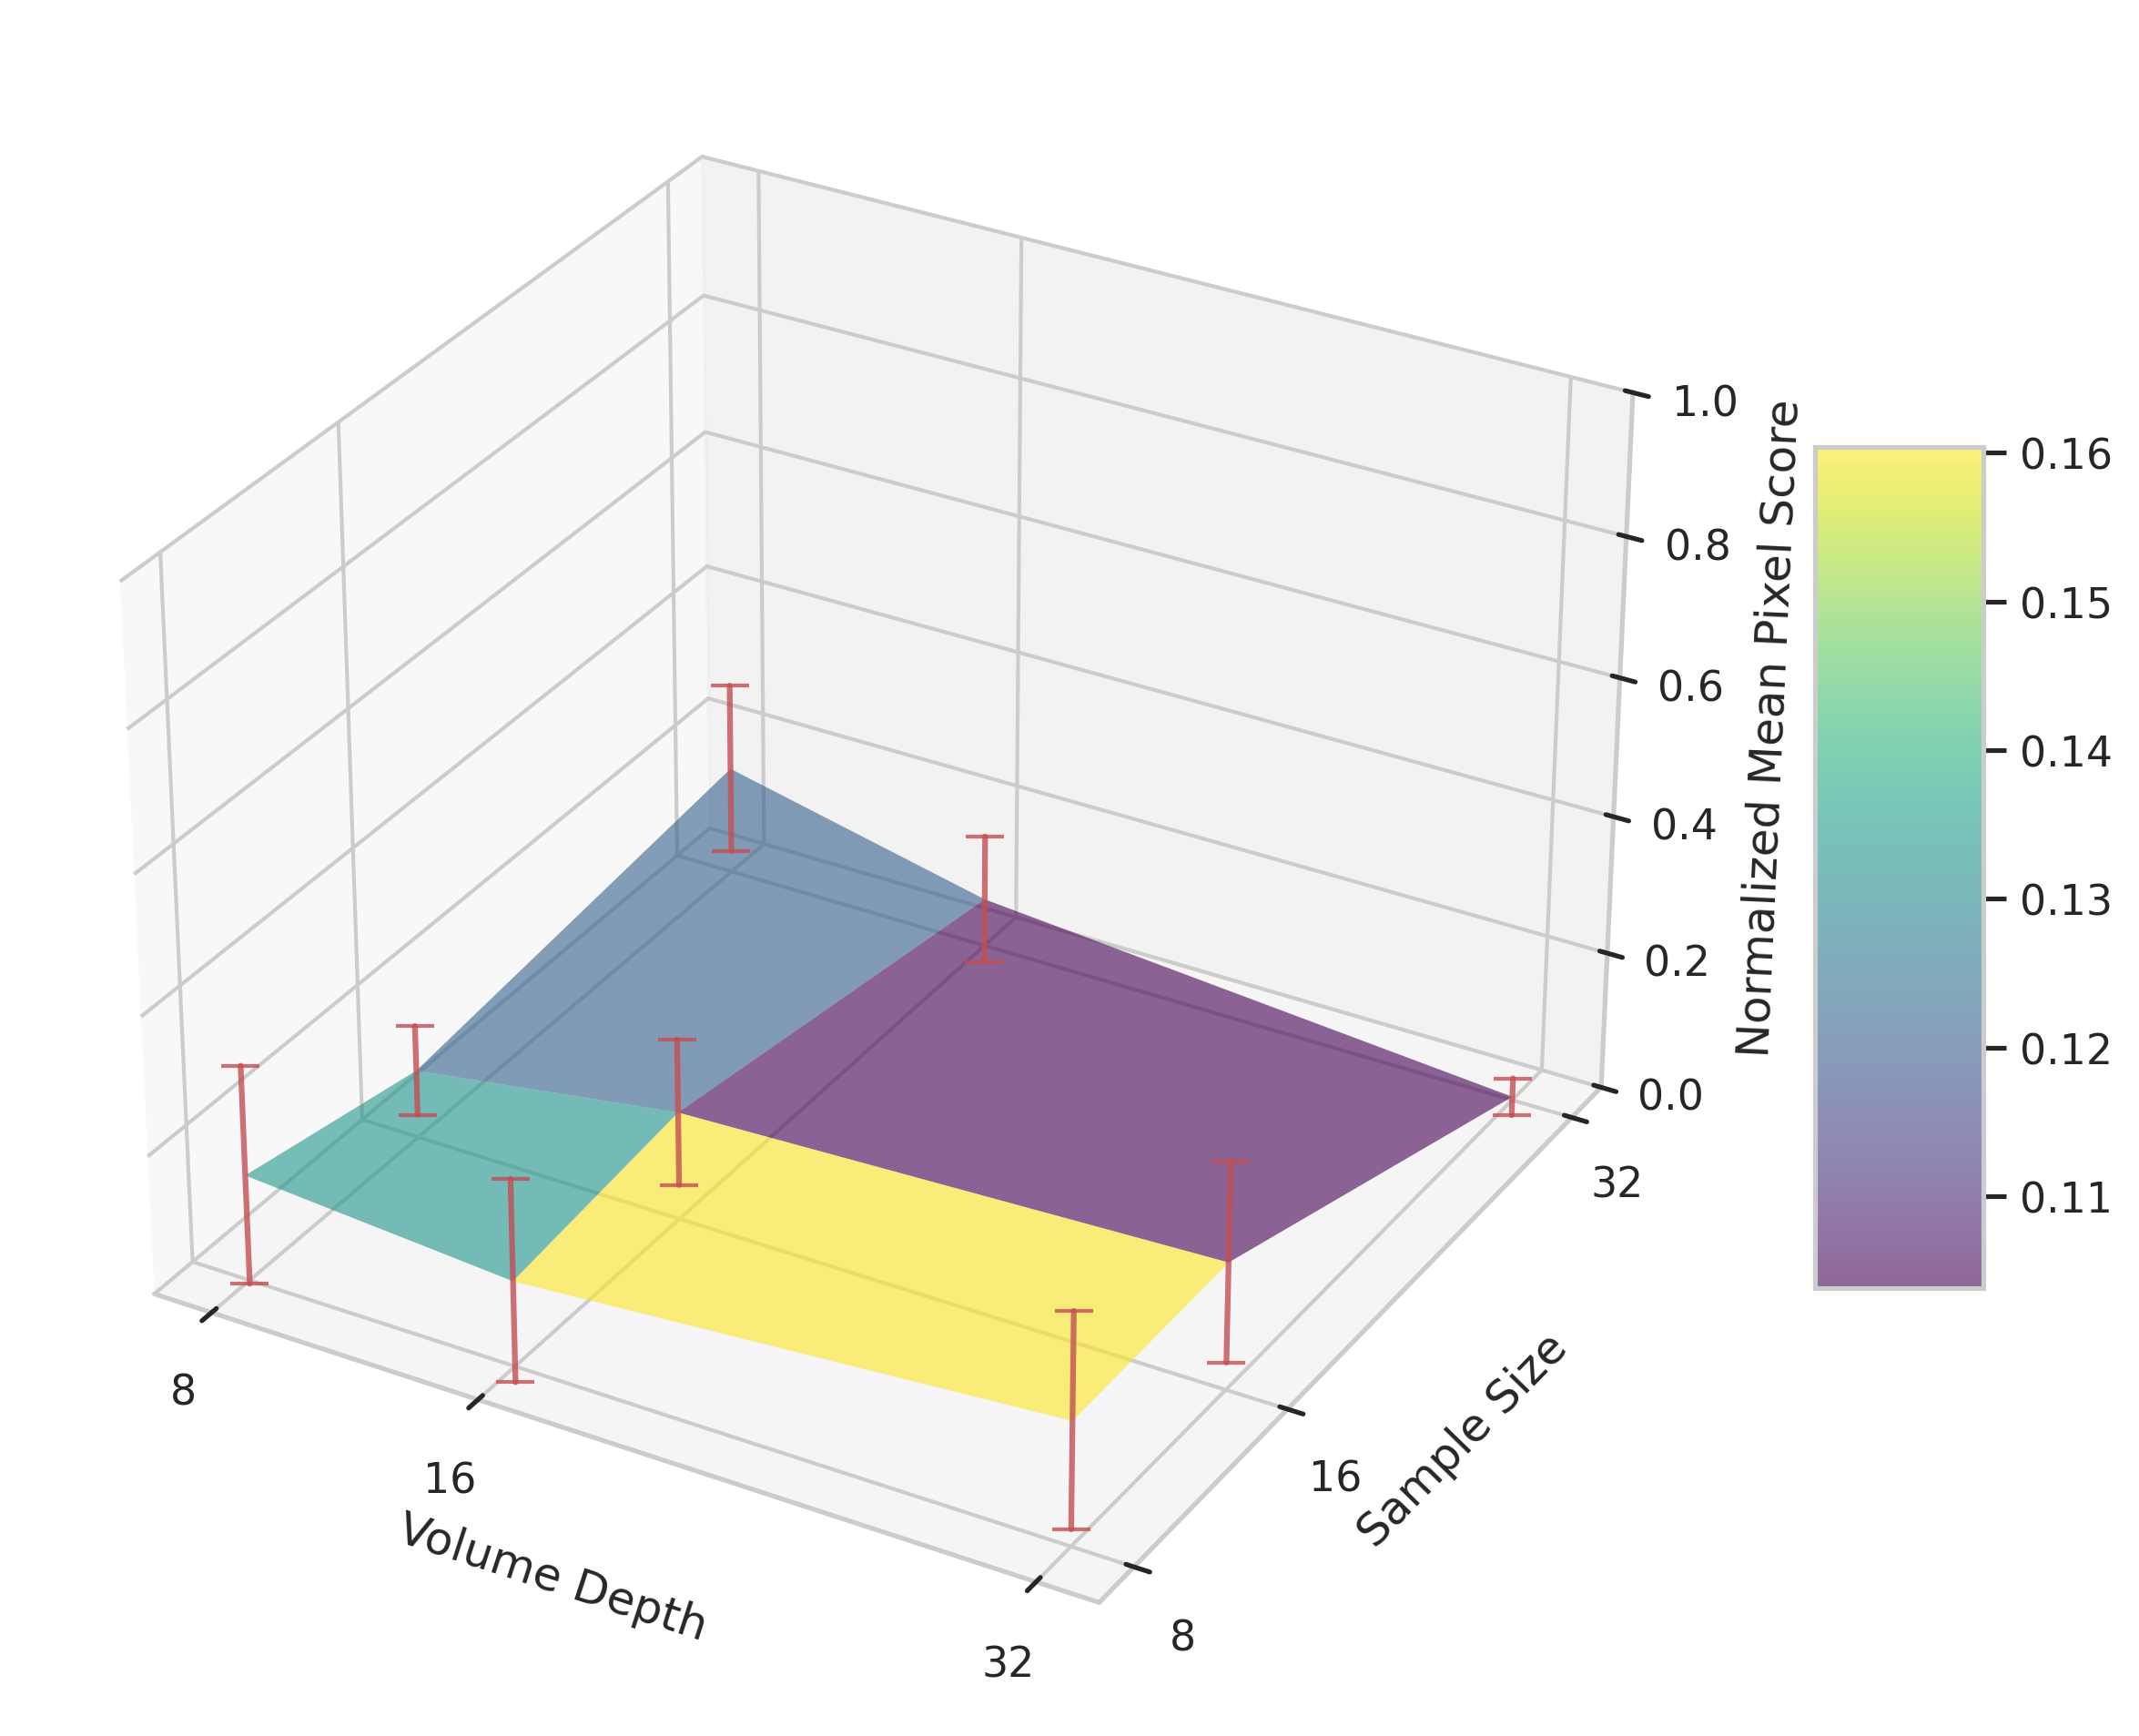

Sample Size: 8, Volume Depth: 8, Mean: [0.20460906], Std: [0.171445]
Sample Size: 16, Volume Depth: 8, Mean: [0.12947557], Std: [0.14354925]
Sample Size: 32, Volume Depth: 8, Mean: [0.0844624], Std: [0.12144803]
Sample Size: 8, Volume Depth: 16, Mean: [0.18882858], Std: [0.16156647]
Sample Size: 16, Volume Depth: 16, Mean: [0.14444504], Std: [0.13010588]
Sample Size: 32, Volume Depth: 16, Mean: [0.22632795], Std: [0.17798389]
Sample Size: 8, Volume Depth: 32, Mean: [0.11326182], Std: [0.14956336]
Sample Size: 16, Volume Depth: 32, Mean: [0.10921516], Std: [0.11023724]
Sample Size: 32, Volume Depth: 32, Mean: [0.07504905], Std: [0.1170106]


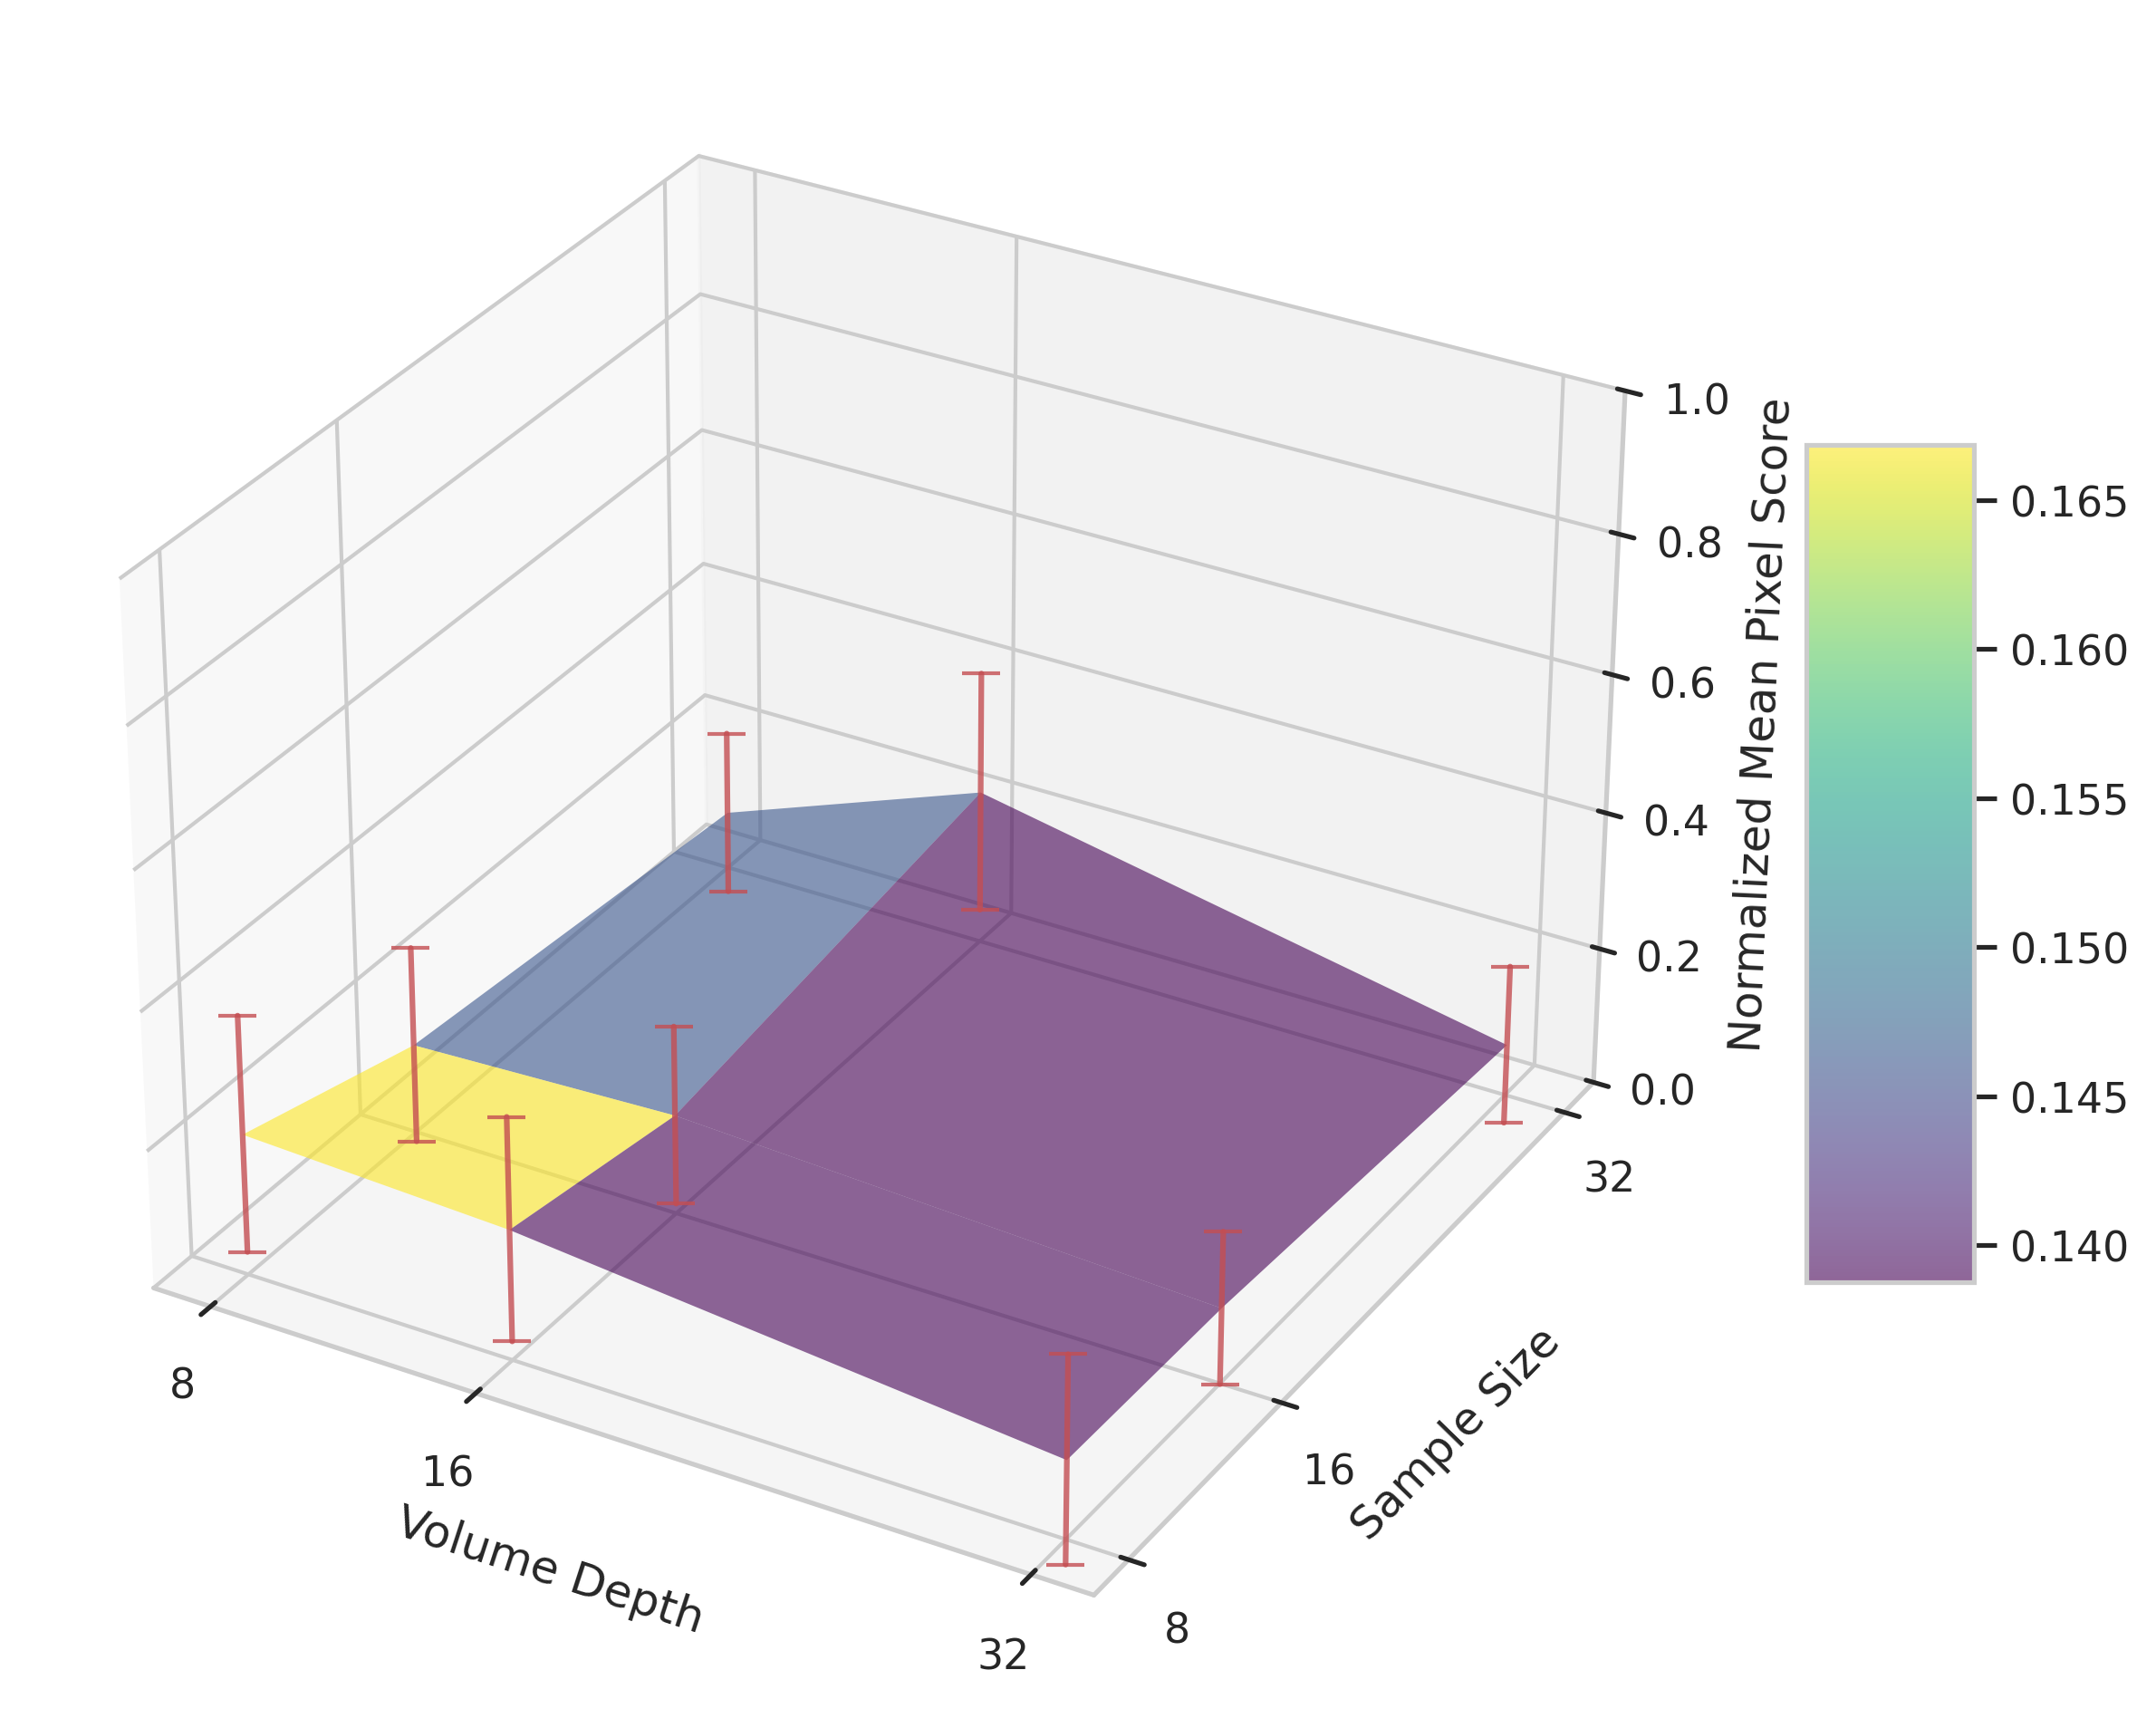

Sample Size: 8, Volume Depth: 8, Mean: [0.20220549], Std: [0.21150163]
Sample Size: 16, Volume Depth: 8, Mean: [0.16462222], Std: [0.20604706]
Sample Size: 32, Volume Depth: 8, Mean: [0.13260955], Std: [0.18999478]
Sample Size: 8, Volume Depth: 16, Mean: [0.15642947], Std: [0.15756326]
Sample Size: 16, Volume Depth: 16, Mean: [0.12638803], Std: [0.18109775]
Sample Size: 32, Volume Depth: 16, Mean: [0.20838807], Std: [0.24687903]
Sample Size: 8, Volume Depth: 32, Mean: [0.10324747], Std: [0.15669632]
Sample Size: 16, Volume Depth: 32, Mean: [0.27266076], Std: [0.24676845]
Sample Size: 32, Volume Depth: 32, Mean: [0.41194974], Std: [0.18266939]


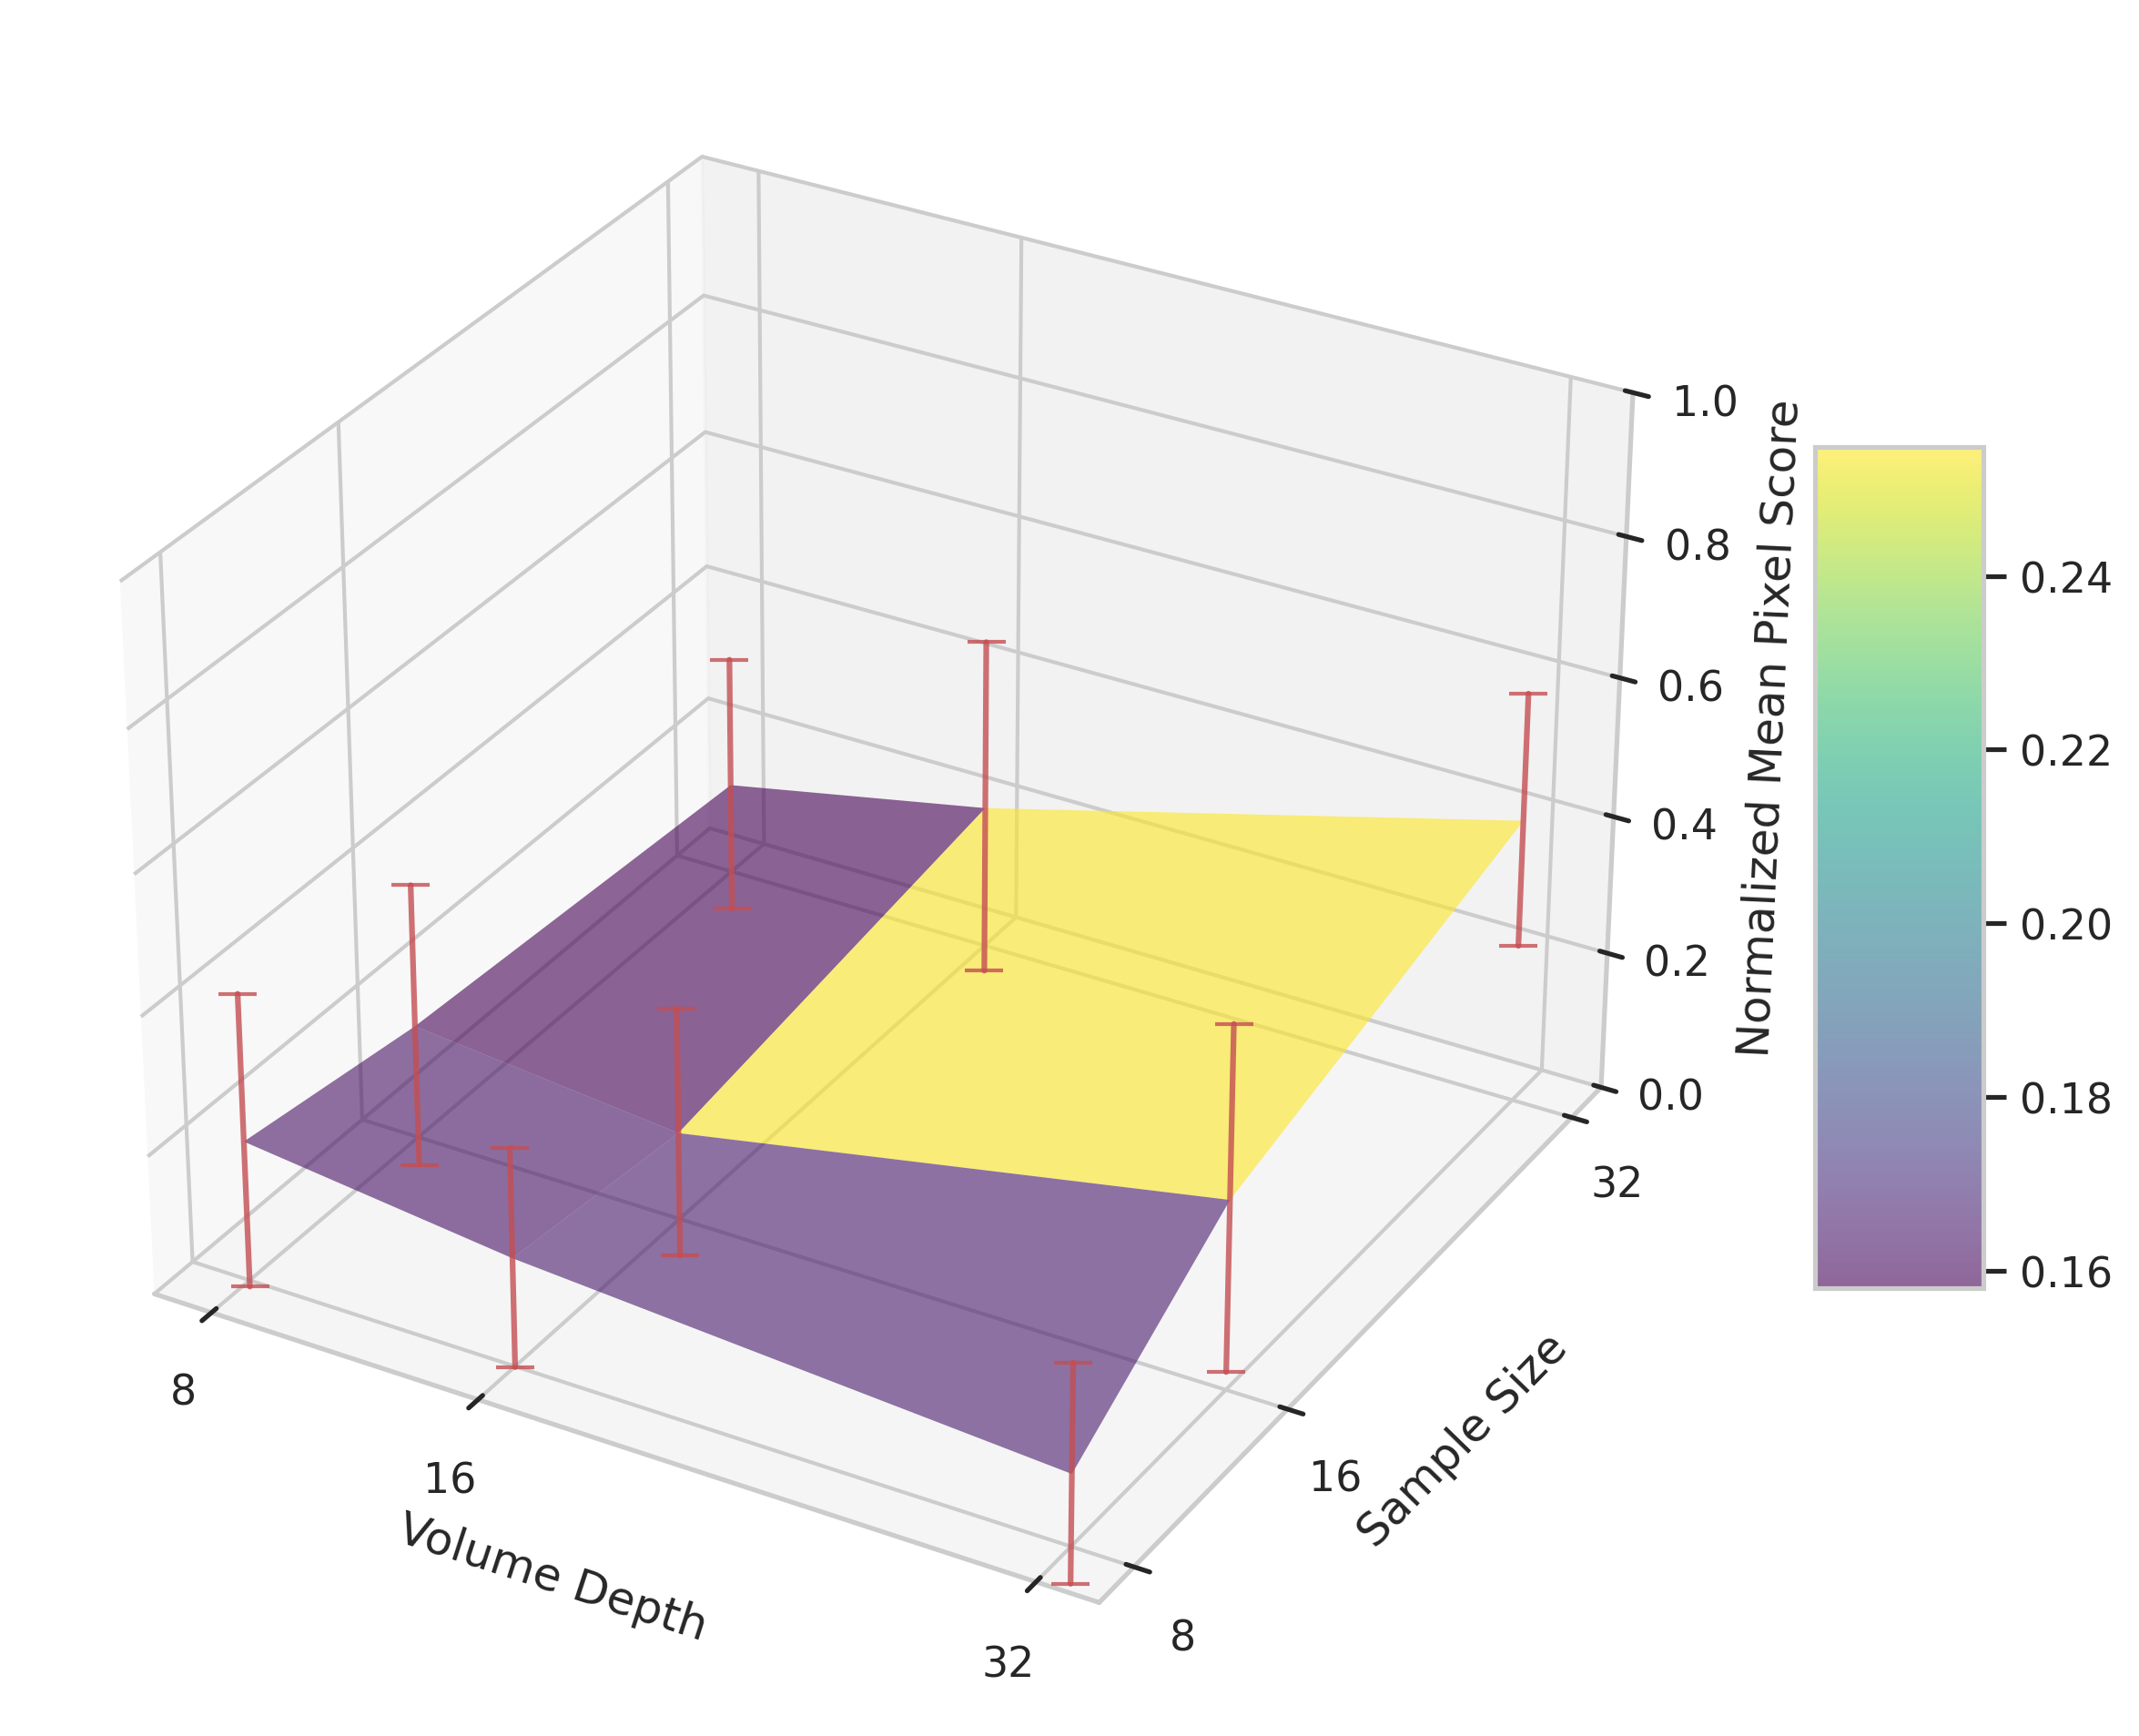

In [9]:
plot_3d_surface(df6040_run0, "60-40")
plot_3d_surface(df8020_run0, "80-20")
plot_3d_surface(df9505_run0, "95-05")

Sample Size: 8, Volume Depth: 8, Mean: [0.15054947], Std: [0.18373714]
Sample Size: 16, Volume Depth: 8, Mean: [0.09894605], Std: [0.08977754]
Sample Size: 32, Volume Depth: 8, Mean: [0.17276379], Std: [0.16076744]
Sample Size: 8, Volume Depth: 16, Mean: [0.11845443], Std: [0.16580153]
Sample Size: 16, Volume Depth: 16, Mean: [0.15433254], Std: [0.13061557]
Sample Size: 32, Volume Depth: 16, Mean: [0.08401948], Std: [0.14379644]
Sample Size: 8, Volume Depth: 32, Mean: [0.18091503], Std: [0.1873873]
Sample Size: 16, Volume Depth: 32, Mean: [0.18816214], Std: [0.19891693]
Sample Size: 32, Volume Depth: 32, Mean: [0.00556594], Std: [0.03944254]
Sample Size: 8, Volume Depth: 8, Mean: [0.20835917], Std: [0.21110504]
Sample Size: 16, Volume Depth: 8, Mean: [0.12993868], Std: [0.16608015]
Sample Size: 32, Volume Depth: 8, Mean: [0.08775107], Std: [0.13508976]
Sample Size: 8, Volume Depth: 16, Mean: [0.18865002], Std: [0.1920113]
Sample Size: 16, Volume Depth: 16, Mean: [0.1456148], Std: [0.15

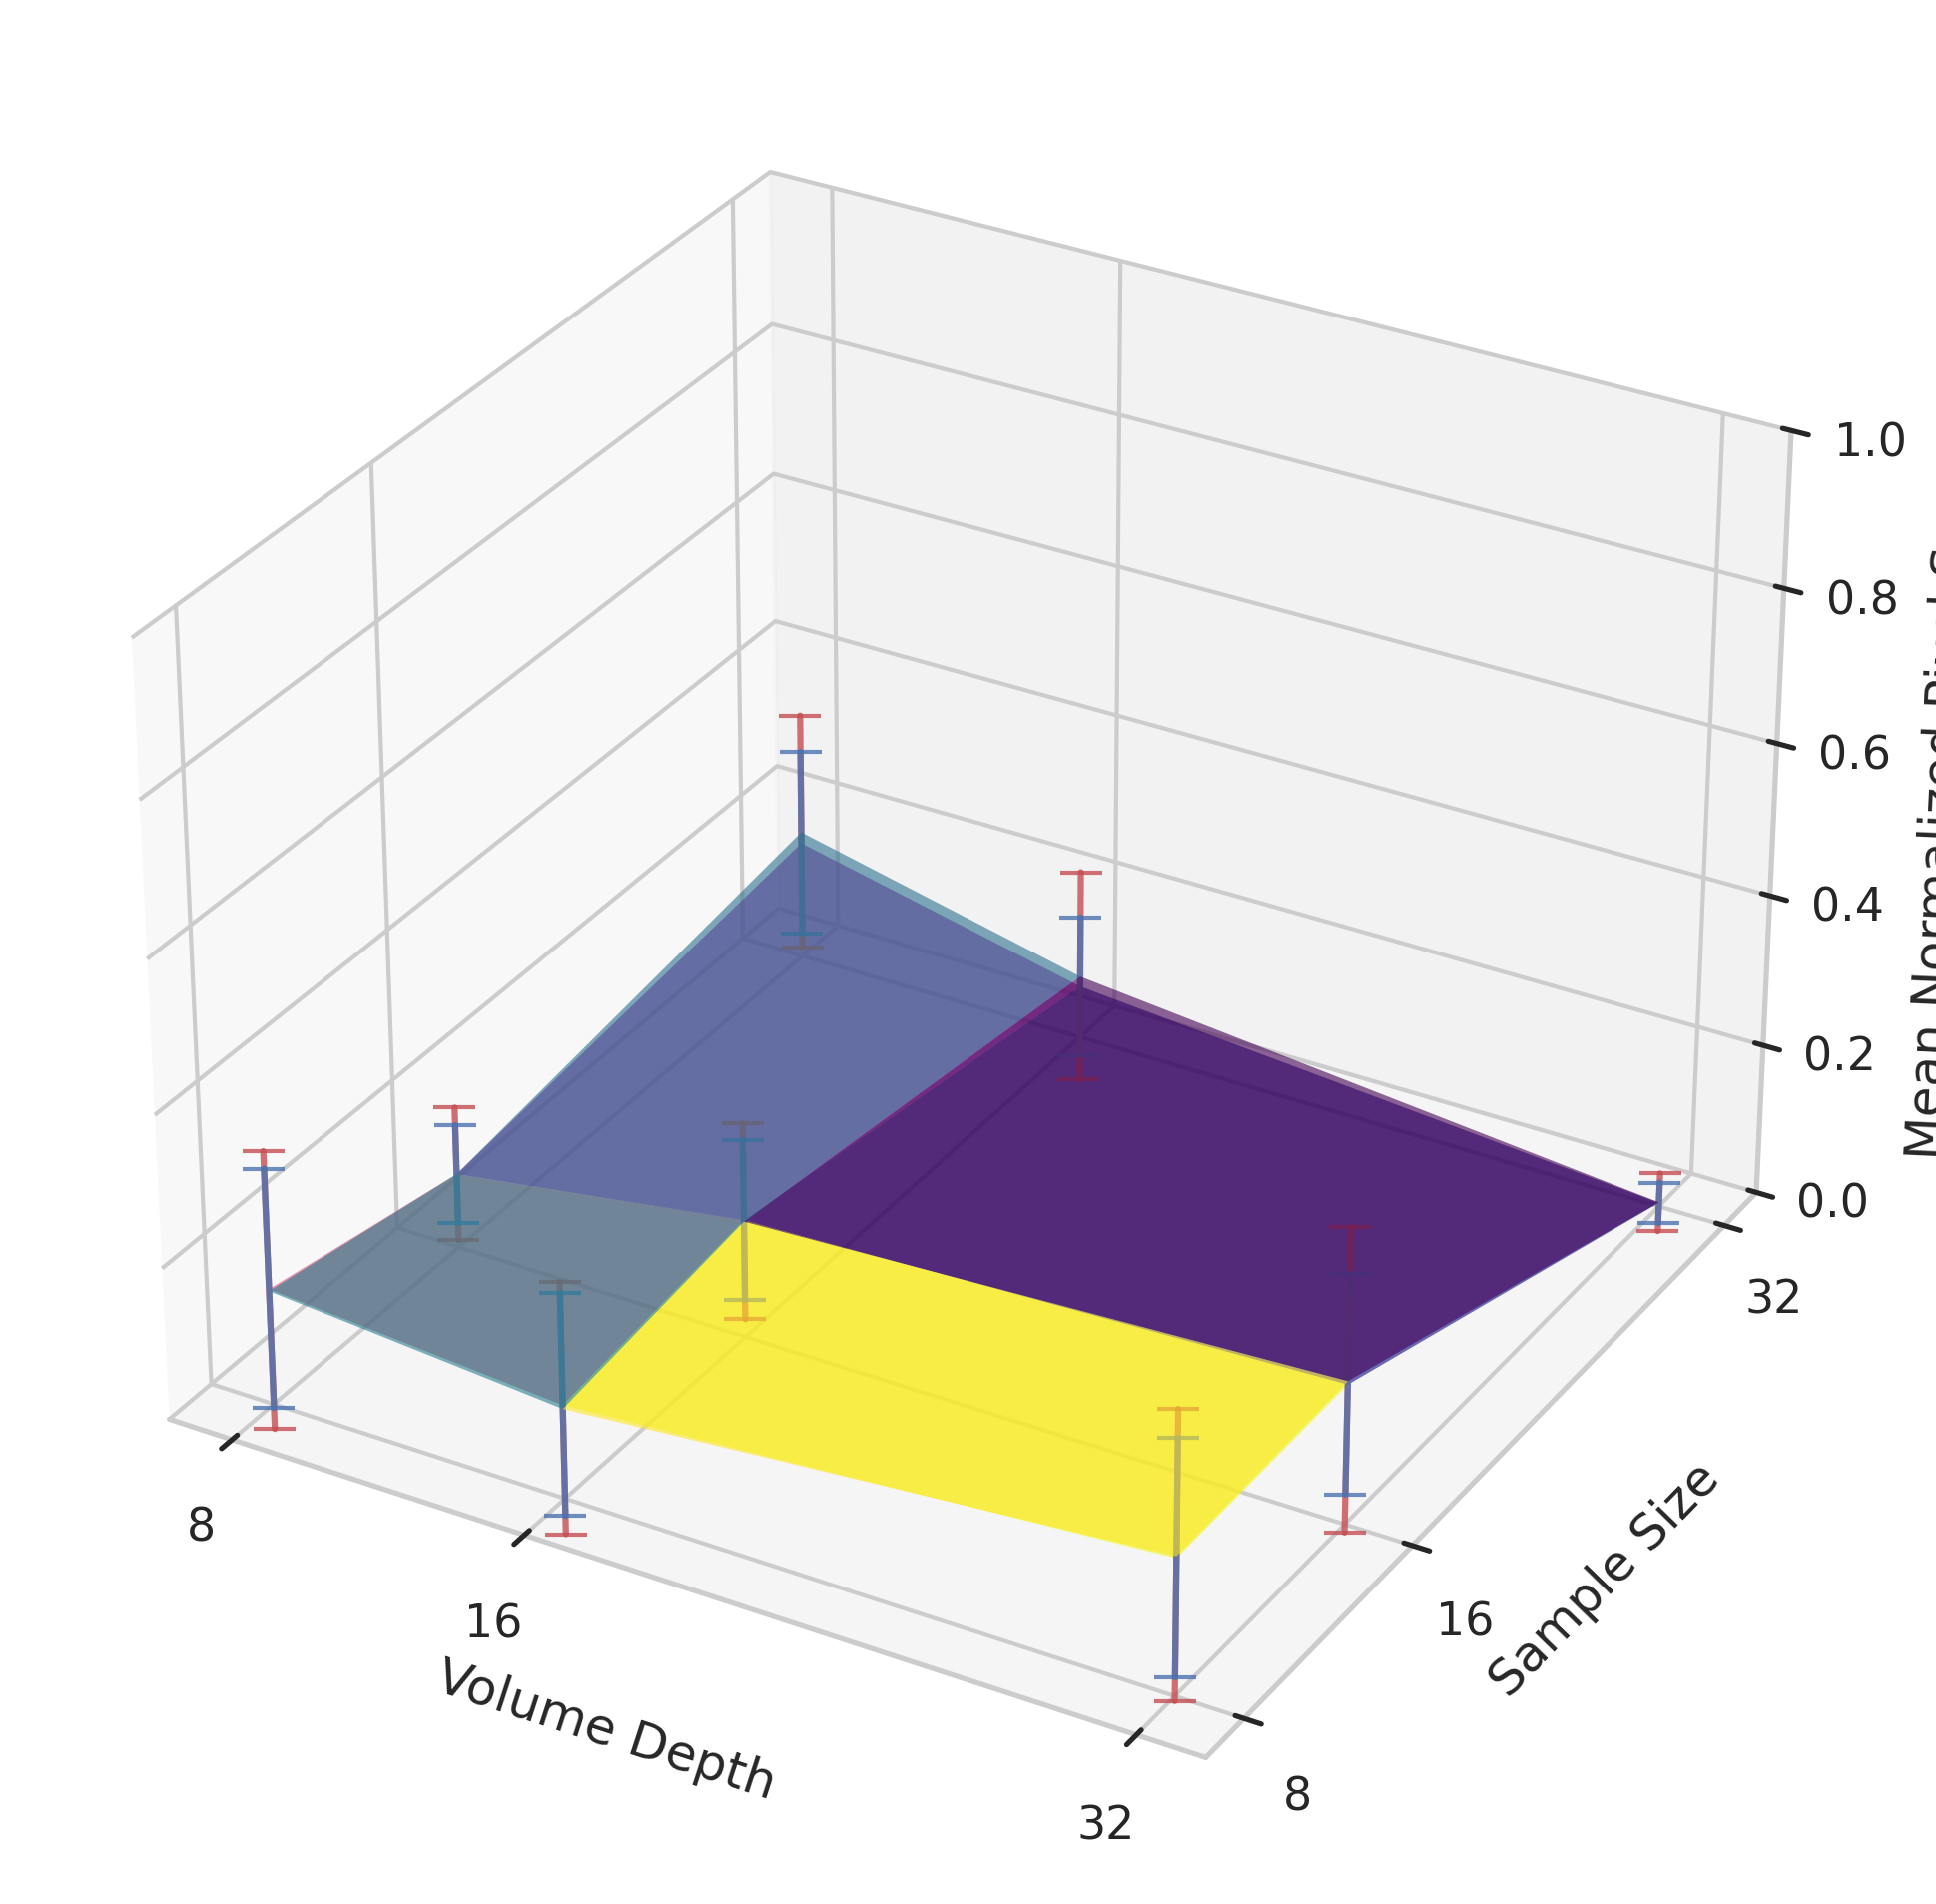

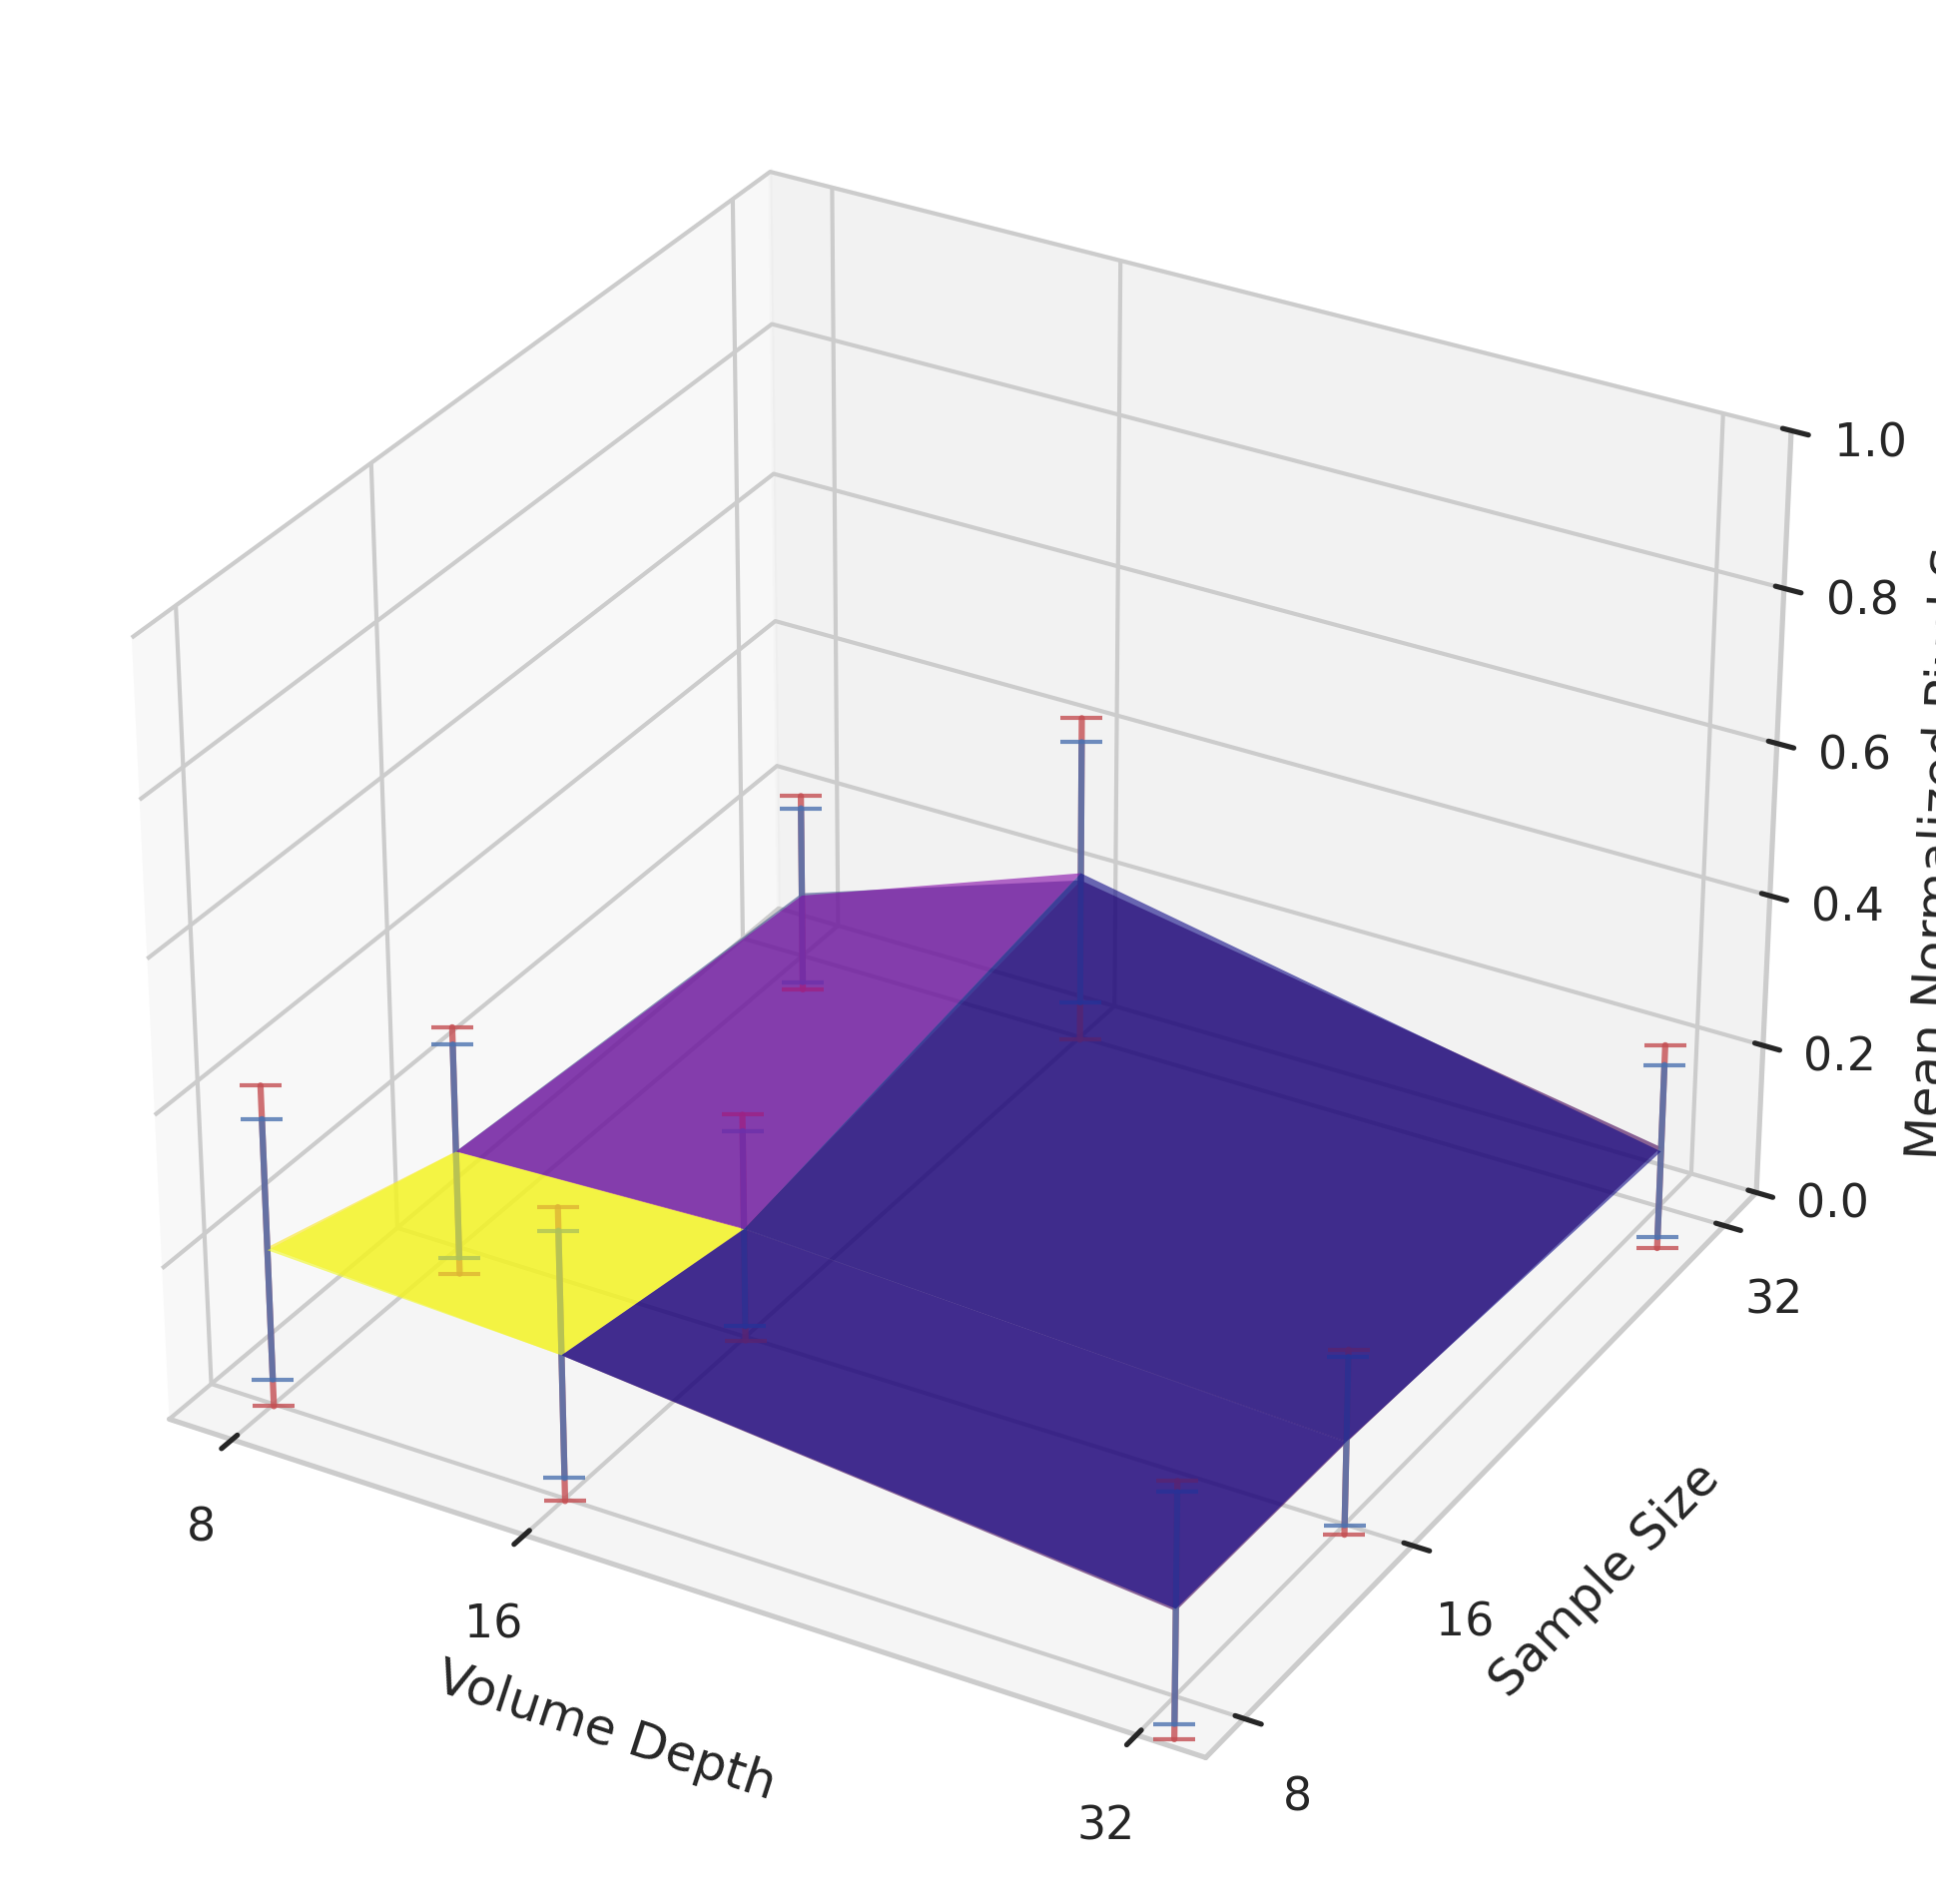

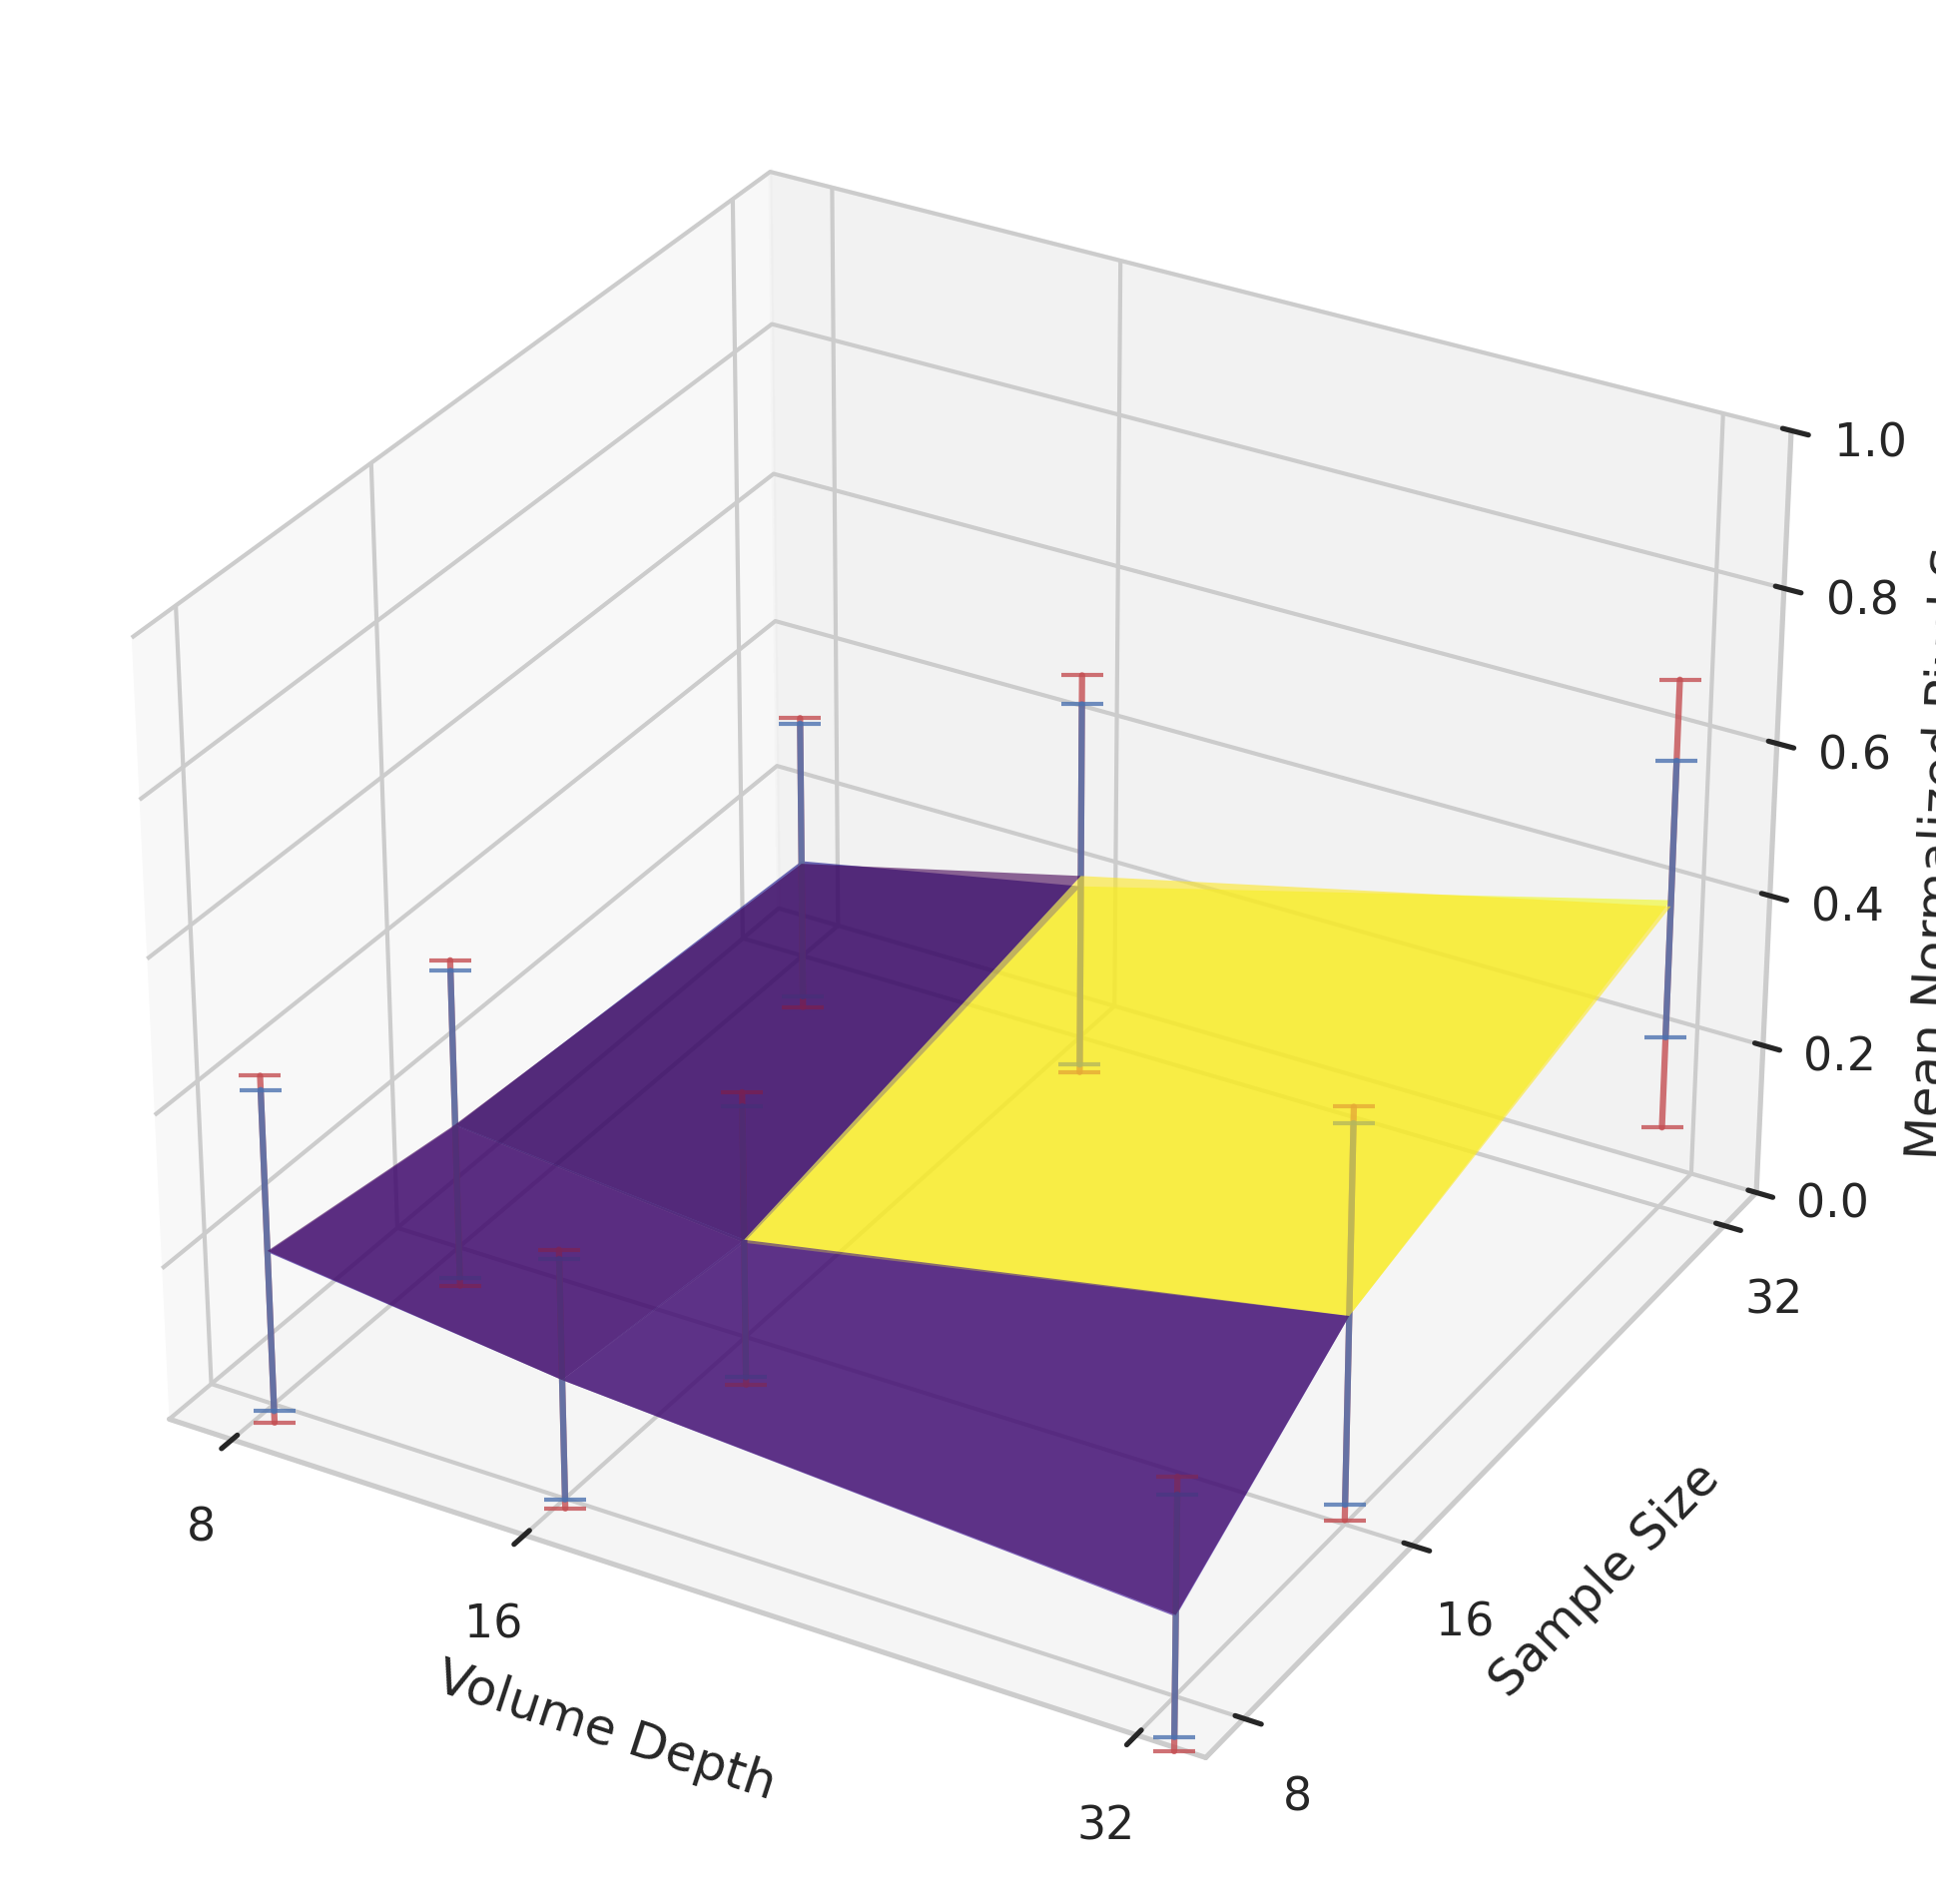

In [10]:
#combine the two plots above into one 3d plot   
def plot_3d_surface_double(df,df2, title):
    fig = plt.figure(figsize=(10,8),dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    # create a meshgrid of sample_size and volume_depth
    sample_sizes = df["sample_size"].astype(int).unique()
    volume_depths = df["volume_depth"].astype(int).unique()
    X1, Y1 = np.meshgrid(sample_sizes, volume_depths)
    X2, Y2 = np.meshgrid(sample_sizes, volume_depths)
    # get the mean values for each combination of sample_size and volume_depth
    Z1 = np.zeros(X1.shape)
    Z2 = np.zeros(X2.shape)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            sample_size = X1[i, j]
            volume_depth = Y1[i, j]
            mean_value1 = df[(df["sample_size"] == sample_size) & (df["volume_depth"] == volume_depth)]["mean"].values
            mean_value2 = df2[(df2["sample_size"] == sample_size) & (df2["volume_depth"] == volume_depth)]["mean"].values
            if len(mean_value2) > 0:
                Z2[i, j] = mean_value2[0]
            else:
                Z2[i, j] = np.nan
            if len(mean_value1) > 0:
                Z1[i, j] = mean_value1[0]
            else:
                Z1[i, j] = np.nan
    # plot the surface
    surf = ax.plot_surface(Y1, X1, Z1, cmap='viridis', edgecolor='none', alpha=0.6)
    surf2 = ax.plot_surface(Y2, X2, Z2, cmap='plasma', edgecolor='none', alpha=0.6) 
    #fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    
    # calculate the std and add it as error bars to each point
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            sample_size = X1[i, j]
            volume_depth = Y1[i, j]
            std_value = df[(df["sample_size"] == sample_size) & (df["volume_depth"] == volume_depth)]["std"].values
            mean_value = df[(df["sample_size"] == sample_size) & (df["volume_depth"] == volume_depth)]["mean"].values
            std_value2 = df2[(df2["sample_size"] == sample_size) & (df2["volume_depth"] == volume_depth)]["std"].values
            mean_value2 = df2[(df2["sample_size"] == sample_size) & (df2["volume_depth"] == volume_depth)]["mean"].values
            print(f"Sample Size: {sample_size}, Volume Depth: {volume_depth}, Mean: {mean_value}, Std: {std_value}")
            if len(std_value) > 0 and len(mean_value) > 0:
                ax.plot([volume_depth, volume_depth], [sample_size, sample_size], 
                        [mean_value[0] - std_value[0], mean_value[0] + std_value[0]], 
                        color='r', alpha=0.8, marker='_',markersize=10)
            if len(std_value2) > 0 and len(mean_value2) > 0:
                ax.plot([volume_depth, volume_depth], [sample_size, sample_size], 
                        [mean_value2[0] - std_value2[0], mean_value2[0] + std_value2[0]], 
                        color='b', alpha=0.8, marker='_',markersize=10)
            

    ax.set_ylabel('Sample Size')
    ax.set_xlabel('Volume Depth')
    ax.set_zlabel('Mean Normalized Pixel Score')
    #set z limit to 0,1
    ax.set_zlim(0.0, 1)
    ax.set_xticks(volume_depths)
    ax.set_xticklabels(volume_depths)
    ax.set_yticks(sample_sizes)
    ax.set_yticklabels(sample_sizes)

plot_3d_surface_double(df6040_rundataset,df6040_run0, "60-40")
plot_3d_surface_double(df8020_rundataset,df8020_run0, "80-20")
plot_3d_surface_double(df9505_rundataset,df9505_run0, "95-05")
